# <div style="text-align: center"> <font size=+5> <ins>ANALYSE DATA</ins> </font> </div>
___

# Loading variables

In [1]:
#imports
import numpy as np
import pandas as pd

import os

import warnings

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#settings
plt.rcParams.update({'figure.figsize': [6.0, 4.0],
                     'figure.dpi' : 300,
                     'font.size': 12.0, 
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

pd.set_option('display.max_columns', 500)

___
# Trends by region

In [ ]:
data_issp = pd.read_pickle("Processed_Data/questionnaires/issp_questionnaires_common.pickle").loc[:,("Questions", slice(None))].droplevel("Variable Type", axis=1)
data_issp["Weight"] = pd.read_pickle("Processed_Data/questionnaires/issp_questionnaires_common.pickle").loc[:,("Respondent Data", "Weight")]
data_issp.columns.name = None

data_GDPgrowth = pd.read_pickle("Processed_Data/indicators/GDP_growth.pickle")
data_GDPpcap = pd.read_pickle("Processed_Data/indicators/GDP_pcap.pickle")
worldmap = pd.read_pickle("Processed_Data/misc/worldmap.pickle")

In [ ]:
def conv_answers(label):
    convDict = {
        "Strongly Disagree" : -2,
        "Disagree" : -1,
        "Neither Agree nor Disagree" : 0,
        "Agree" : 1,
        "Strongly Agree" : 2,

        "Yes" : 1,
        "No" : -1,

        'Extremely dangerous': 2,
        'Very dangerous': 1,
        'Somewhat dangerous': 0,
        'Not very dangerous': -1,
        'Not dangerous at all': -2,

        "Always" : 3,
        "Often" : 2,
        "Sometimes" : 1,
        "Never" : 0,

        'Very willing': 2,
        'Fairly willing': 1,
        'Neither willing nor unwilling': 0,
        'Fairly unwilling': -1,
        'Very unwilling': -2
    }
    return convDict[label] if label in convDict else label

In [ ]:
def get_region(country):
    if country in ["Germany", "United Kingdom", "Hungary", "Italy", "Ireland", "Netherlands", "Norway", "Czechia", "Slovenia", "Poland", "Bulgaria", "Spain", "Austria", "Sweden", "Latvia", "Portugal", "Denmark", "Switzerland", "Finland", "Belgium", "France", "Croatia", "Iceland", "Lithuania", "Slovakia"]:
        return "Europe"
    elif country in ["Russia", "Philippines", "Israel", "Japan", "South Corea", "Turkiye", "South Africa", "Taiwan", "China", "India", "Thailand", "Chile", "Mexico", "Argentina"]:
        return "Asia / Africa / Central and South America"
    elif country in ["United States", "Canada", "Australia", "New Zealand"]:
        return "North America / Australia / New Zealand"
    else:
        return "Other"

In [ ]:
#plotting data
cols = [
    #economy vs environment (link to economic growth)
    'Environmental protection needs economic growth', 'Economic growth harms environment', 
    #environmental activism (link to policy implementation in different states)
    'We worry too much about harming environment', 'In the last five years, participated in an environmental demonstration',
    #perception of danger to environment (link to actual environmental data -> pollution levels / deaths because of pollution...)
    'Danger to the environment (Air pollution by cars)', 'Danger to the environment (Air pollution by industry)', 'Danger to the environment (River, lake and stream pollution)',
    #climate change (link to countries most affected by climate change -> extreme climate events...?
    'Danger to the environment (Rise in the world’s temperature)'
]
        

cols = list(data_issp.columns.drop(["Weight", "Highest priority for country", "Second highest priority for country"])) #uncomment to plot all columns


data = data_issp[cols].copy()
data = data.map(conv_answers).astype(float)
data = data.mul(data_issp["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data_issp["Weight"].groupby(["Year", "Country"]).sum(), axis="index")
data["Region"] = data.index.get_level_values("Country").map(get_region)

def set_y_axis(ax, data, type):
    ticks = [data.min(), data.max()]
    if ticks[0] < 0 and ticks[1]>0:
        ticks = [ticks[0], 0, ticks[1]]
        label = {
            "agree" : [f"Agree less ({ticks[0]:.2f})", "50% agree (0)", f"Agree more ({ticks[2]:.2f})"],
            "yesno" : [f"More No ({ticks[0]:.2f})", "50% Yes - 50% No (0)", f"More Yes ({ticks[2]:.2f})"],
            "danger" : [f"Dangerous ({ticks[0]:.2f})", "Somewhat dangerous (0)", f"Not Dangerous ({ticks[2]:.2f})"],
            "will" : [f"Unwilling ({ticks[0]:.2f})", "50% willing (0)", f"Willing ({ticks[2]:.2f})"],
        }[type]
    else:
        label = {
            "agree" : [f"Agree less ({ticks[0]:.2f})", f"Agree more ({ticks[1]:.2f})"],
            "yesno" : [f"More No ({ticks[0]:.2f})", f"More Yes ({ticks[1]:.2f})"],
            "danger" : [f"Less Dangerous ({ticks[0]:.2f})", f"More Dangerous ({ticks[1]:.2f})"],
            "freq" : [f"Less Often ({ticks[0]:.2f})", f"More Often ({ticks[1]:.2f})"],
            "will" : [f"Less Willing ({ticks[0]:.2f})", f"More Willing ({ticks[1]:.2f})"],
        }[type]
    ax.set_yticks(ticks)
    ax.set_yticklabels(label)

for i,col in enumerate(cols):
    fig, axs = plt.subplots(1,2, figsize=(6.4*2,4.8), gridspec_kw={'width_ratios': [1.6, 1]})
    fig.suptitle(col, fontsize=20)
    
    dataplot = data.groupby(["Year", "Region"]).mean().reset_index()
    sns.lineplot(data=dataplot, x="Year", y=col, hue="Region", palette="colorblind", ax=axs[0])
    
    axs[0].set_xticks([1993,2000,2010,2020])
    
    axs[0].set_ylabel("Mean Answer")
    
    if "Agree" in data_issp[col].values:
        set_y_axis(axs[0], dataplot[col], "agree")
    if "Yes" in data_issp[col].values:
        set_y_axis(axs[0], dataplot[col], "yesno")
    if "Extremely dangerous" in data_issp[col].values:
        set_y_axis(axs[0], dataplot[col], "danger")
    if "Always" in data_issp[col].values:
        set_y_axis(axs[0], dataplot[col], "freq")
    if "Very willing" in data_issp[col].values:
        set_y_axis(axs[0], dataplot[col], "will")
    
    sns.move_legend(axs[0], "upper right")
    
    sns.histplot(data=data_issp.reset_index(), x=col, hue="Year", stat="percent", shrink=0.9, multiple="dodge", palette="colorblind", common_norm=False, ax=axs[1])
    axs[1].set_xlabel("")
    for tick in axs[1].get_xticklabels() + axs[0].get_yticklabels():
        tick.set_fontsize(8)
        tick.set_horizontalalignment('right')
        tick.set_rotation(30)
    
    plt.tight_layout()


del(data, dataplot, set_y_axis)

___
# Economy and the environment

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6.4*2,4.8*2))
fig.suptitle("Economic growth and harm to environment", fontsize=20)

for i, year in enumerate([1993,2000,2010,2020]):
    growing_countries = [c for c in data_GDPgrowth.index.drop("World") if data_GDPgrowth.loc[c, year] >= data_GDPgrowth.drop(index="World")[year].median()]

    ax = axs[i//2,i%2]
    data = data_issp.loc[(year, slice(None)),:].reset_index().copy()
    data["Growth"] = data["Country"].map(lambda x: "Top 50%" if x in growing_countries else "Bottom 50%")
    data = data.sort_values("Growth", axis=0, ascending=False)
    sns.histplot(data=data.query("Country != 'Taiwan'"), x="Economic growth harms environment", hue="Growth", weights="Weight", common_norm=False, multiple="dodge", stat="percent", shrink=0.8, palette="colorblind", ax=ax)
    ax.set_title(year)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(8)
        tick.set_horizontalalignment('right')
        tick.set_rotation(30)
plt.tight_layout()


fig, axs = plt.subplots(2, 2, figsize=(6.4*2,4.8*2))
fig.suptitle("Economic growth and environmental protection", fontsize=20)

for i, year in enumerate([1993,2000,2010,2020]):
    growing_countries = [c for c in data_GDPgrowth.index.drop("World") if data_GDPgrowth.loc[c, year] >= data_GDPgrowth.drop(index="World")[year].median()]

    ax = axs[i//2,i%2]
    data = data_issp.loc[(year, slice(None)),:].reset_index().copy()
    data["Growth"] = data["Country"].map(lambda x: "Top 50%" if x in growing_countries else "Bottom 50%")
    data = data.sort_values("Growth", axis=0, ascending=False)
    sns.histplot(data=data.query("Country != 'Taiwan'"), x="Environmental protection needs economic growth", hue="Growth", weights="Weight", common_norm=False, multiple="dodge", stat="percent", shrink=0.8, ax=ax)
    ax.set_title(year)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(8)
        tick.set_horizontalalignment('right')
        tick.set_rotation(30)
plt.tight_layout()

del(data)

In [ ]:
data = data_issp.query("Country != 'Taiwan'").loc[:,["Economic growth harms environment", "Environmental protection needs economic growth", "Weight"]].copy()
data = data.map(conv_answers).astype(float)
data = data[["Economic growth harms environment", "Environmental protection needs economic growth"]].mul(data["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data["Weight"].groupby(["Year", "Country"]).sum(), axis="index")
data["GDP per capita (% of world average)"] = data.index.map(lambda x: 100*data_GDPpcap.loc[x[1], x[0]].copy() / data_GDPpcap.loc["World",x[0]].copy())


fig, axs = plt.subplots(1,2,figsize=(6.4*2,4.8), sharey=False)
fig.suptitle("GDP per capita vs people's opinion for each country", fontsize=20)

for i, val in enumerate(["Economic growth harms environment", "Environmental protection needs economic growth"]):
    ax = axs[i]
    sns.scatterplot(data=data.reset_index(), x="GDP per capita (% of world average)", y=val, hue="Year", palette="colorblind", style="Year", ax=ax)
    ax.set_title(val)
    ax.set_ylabel("")
    ax.set_yticks([data[val].min(), 0, data[val].max()])
    ax.set_yticklabels(["More disagree", "50% agree", "More agree"], fontsize=8)

plt.tight_layout()

del(data)

In [ ]:
data = data_issp.query("Country != 'Taiwan'").loc[:,["Economic growth harms environment", "Environmental protection needs economic growth", "Weight"]].copy()
data = data.map(conv_answers).astype(float)
data = data[["Economic growth harms environment","Environmental protection needs economic growth"]].mul(data["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data["Weight"].groupby(["Year", "Country"]).sum(), axis="index")
data["Growth in previous 3 years"] = pd.Categorical(data.index.map(lambda x: (np.nan if np.isnan(data_GDPgrowth.loc[x[1],x[0]]) else ("Bottom 25%" if data_GDPgrowth.loc[x[1],x[0]] < data_GDPgrowth.loc[:,x[0]].quantile(0.25) else "25% to 75%") if data_GDPgrowth.loc[x[1],x[0]] < data_GDPgrowth.loc[:,x[0]].quantile(0.75) else "Top 25%")), ["Top 25%", "25% to 75%", "Bottom 25%"])
data["GDP per capita"] = pd.Categorical(data.index.map(lambda x: ("Bottom 25%" if data_GDPpcap.loc[x[1],x[0]] < data_GDPpcap.loc[:,x[0]].quantile(0.25) else "25% to 75%") if data_GDPpcap.loc[x[1],x[0]] < data_GDPpcap.loc[:,x[0]].quantile(0.75) else "Top 25%"), ["Top 25%", "25% to 75%", "Bottom 25%"])

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for q in ["Economic growth harms environment", "Environmental protection needs economic growth"]:
        fig, axs = plt.subplots(1,2,figsize=(6.4*2,4.8))
        fig.suptitle(f"Trend over the years: {q}", fontsize=20)
        for i, y in enumerate(["GDP per capita", "Growth in previous 3 years"]):
            dataplot = data[[q, y]].groupby(["Year", y]).mean().reset_index()
            sns.lineplot(data=dataplot, x="Year", y=q, hue=y, ax = axs[i])
            axs[i].set_xticks([1993,2000,2010,2020])
            if q == "Economic growth harms environment":
                axs[i].set_yticks([dataplot[q].min(), 0, dataplot[q].max()])
                axs[i].set_yticklabels([f"More disagree\n(score=avg score: {dataplot[q].min():.2f})", "50% agree\n(score=avg score: 0)", f"More agree\n(score=avg score: {dataplot[q].max():.2f})"], fontsize=8)
            elif q == "Environmental protection needs economic growth":
                axs[i].set_yticks([0, dataplot[q].max()])
                axs[i].set_yticklabels(["50% agree\n(score=avg score: 0)", f"More agree\n(score=avg score: {dataplot[q].max():.2f})"], fontsize=8)
        plt.tight_layout()

del(data, dataplot)

In [ ]:
from matplotlib.colors import ListedColormap
for q in ["Economic growth harms environment", "Environmental protection needs economic growth"]:
    data = data_issp.query("Country != 'Taiwan'").loc[:,[q, "Weight"]].copy()
    data = data.map(conv_answers).astype(float)
    data = data[[q]].mul(data["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data["Weight"].groupby(["Year", "Country"]).sum(), axis="index")
    data = data[q].reset_index().pivot(index="Country", columns="Year", values=q)

    cmap = mpl.colormaps.get_cmap('bwr')
    cmap.set_bad("lightgray")
    clm = sns.clustermap(data.map(lambda x: x if not np.isnan(x) else 0), mask=np.isnan(data), col_cluster=False, dendrogram_ratio=0.05, figsize=(6.4,6.4), cbar_pos=(1,0.1,.02,.8), cmap=cmap, center=0, yticklabels=1)

    
    zm = np.ma.masked_invalid(data.map(lambda x: 1 if np.isnan(x) else np.nan).reindex([t.get_text() for t in clm.fig.axes[2].get_yticklabels()]))
    x = np.arange(len(data.columns)+1)
    y = np.arange(len(data.index)+1)
    none_map = ListedColormap(['none'])
    clm.fig.axes[2].pcolor(x, y, zm, cmap=none_map, edgecolor="gray", lw=0, hatch='/////')
    
    plt.gcf().suptitle(q, fontsize=20)
    
    del(data)

___
# Clusters of questions

- Some questions may be grouped into single "topic" -> which ones?

#### Topics:
1. Awareness (Danger to environment (...))
2. Will to act (Willingness to make trade-offs (...), Sort glass, Member of group, Signed petition, Participated in demonstration, Given Money, I do what is right)
3. Efficacy of environmental action (We worry too much..., Too difficult to do much..., Science solves environmental problems)

In [ ]:
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle").loc[:,"Questions"]

def conv_answers(label):
    convDict = {
        "Strongly Disagree" : -2,
        "Disagree" : -1,
        "Neither Agree nor Disagree" : 0,
        "Agree" : 1,
        "Strongly Agree" : 2,

        "Yes" : 1,
        "No" : -1,

        'Extremely dangerous': 2,
        'Very dangerous': 1,
        'Somewhat dangerous': 0,
        'Not very dangerous': -1,
        'Not dangerous at all': -2,

        "Always" : 3,
        "Often" : 2,
        "Sometimes" : 1,
        "Never" : 0,

        'Very willing': 2,
        'Fairly willing': 1,
        'Neither willing nor unwilling': 0,
        'Fairly unwilling': -1,
        'Very unwilling': -2
    }
    return convDict[label] if label in convDict else label

clm = sns.clustermap(data_issp.map(conv_answers).astype(float).corr(), cmap="bwr", center=0, cbar_pos=(0.02, 0.5, 0.02, 0.35), method="ward")
clm.ax_row_dendrogram.set_visible(False)
clm.ax_col_dendrogram.set_visible(False)
clm.tick_params(size=1, pad=1, labelsize=6)

clm.ax_heatmap.set_title("Environmental concern dimensions", fontsize=20);
clm.ax_heatmap.set_xticks([])
clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_ylabel("")


#clm.savefig("../Figures/environmental_concern_dimensions.pdf", format="pdf")

___
# Correlation Between Indicators

/var/folders/mv/3xxn6x011nj1xbbrht5z6r1m0000gn/T/ipykernel_5987/1614421779.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)


Text(2783.2708333333326, 0.5, '')

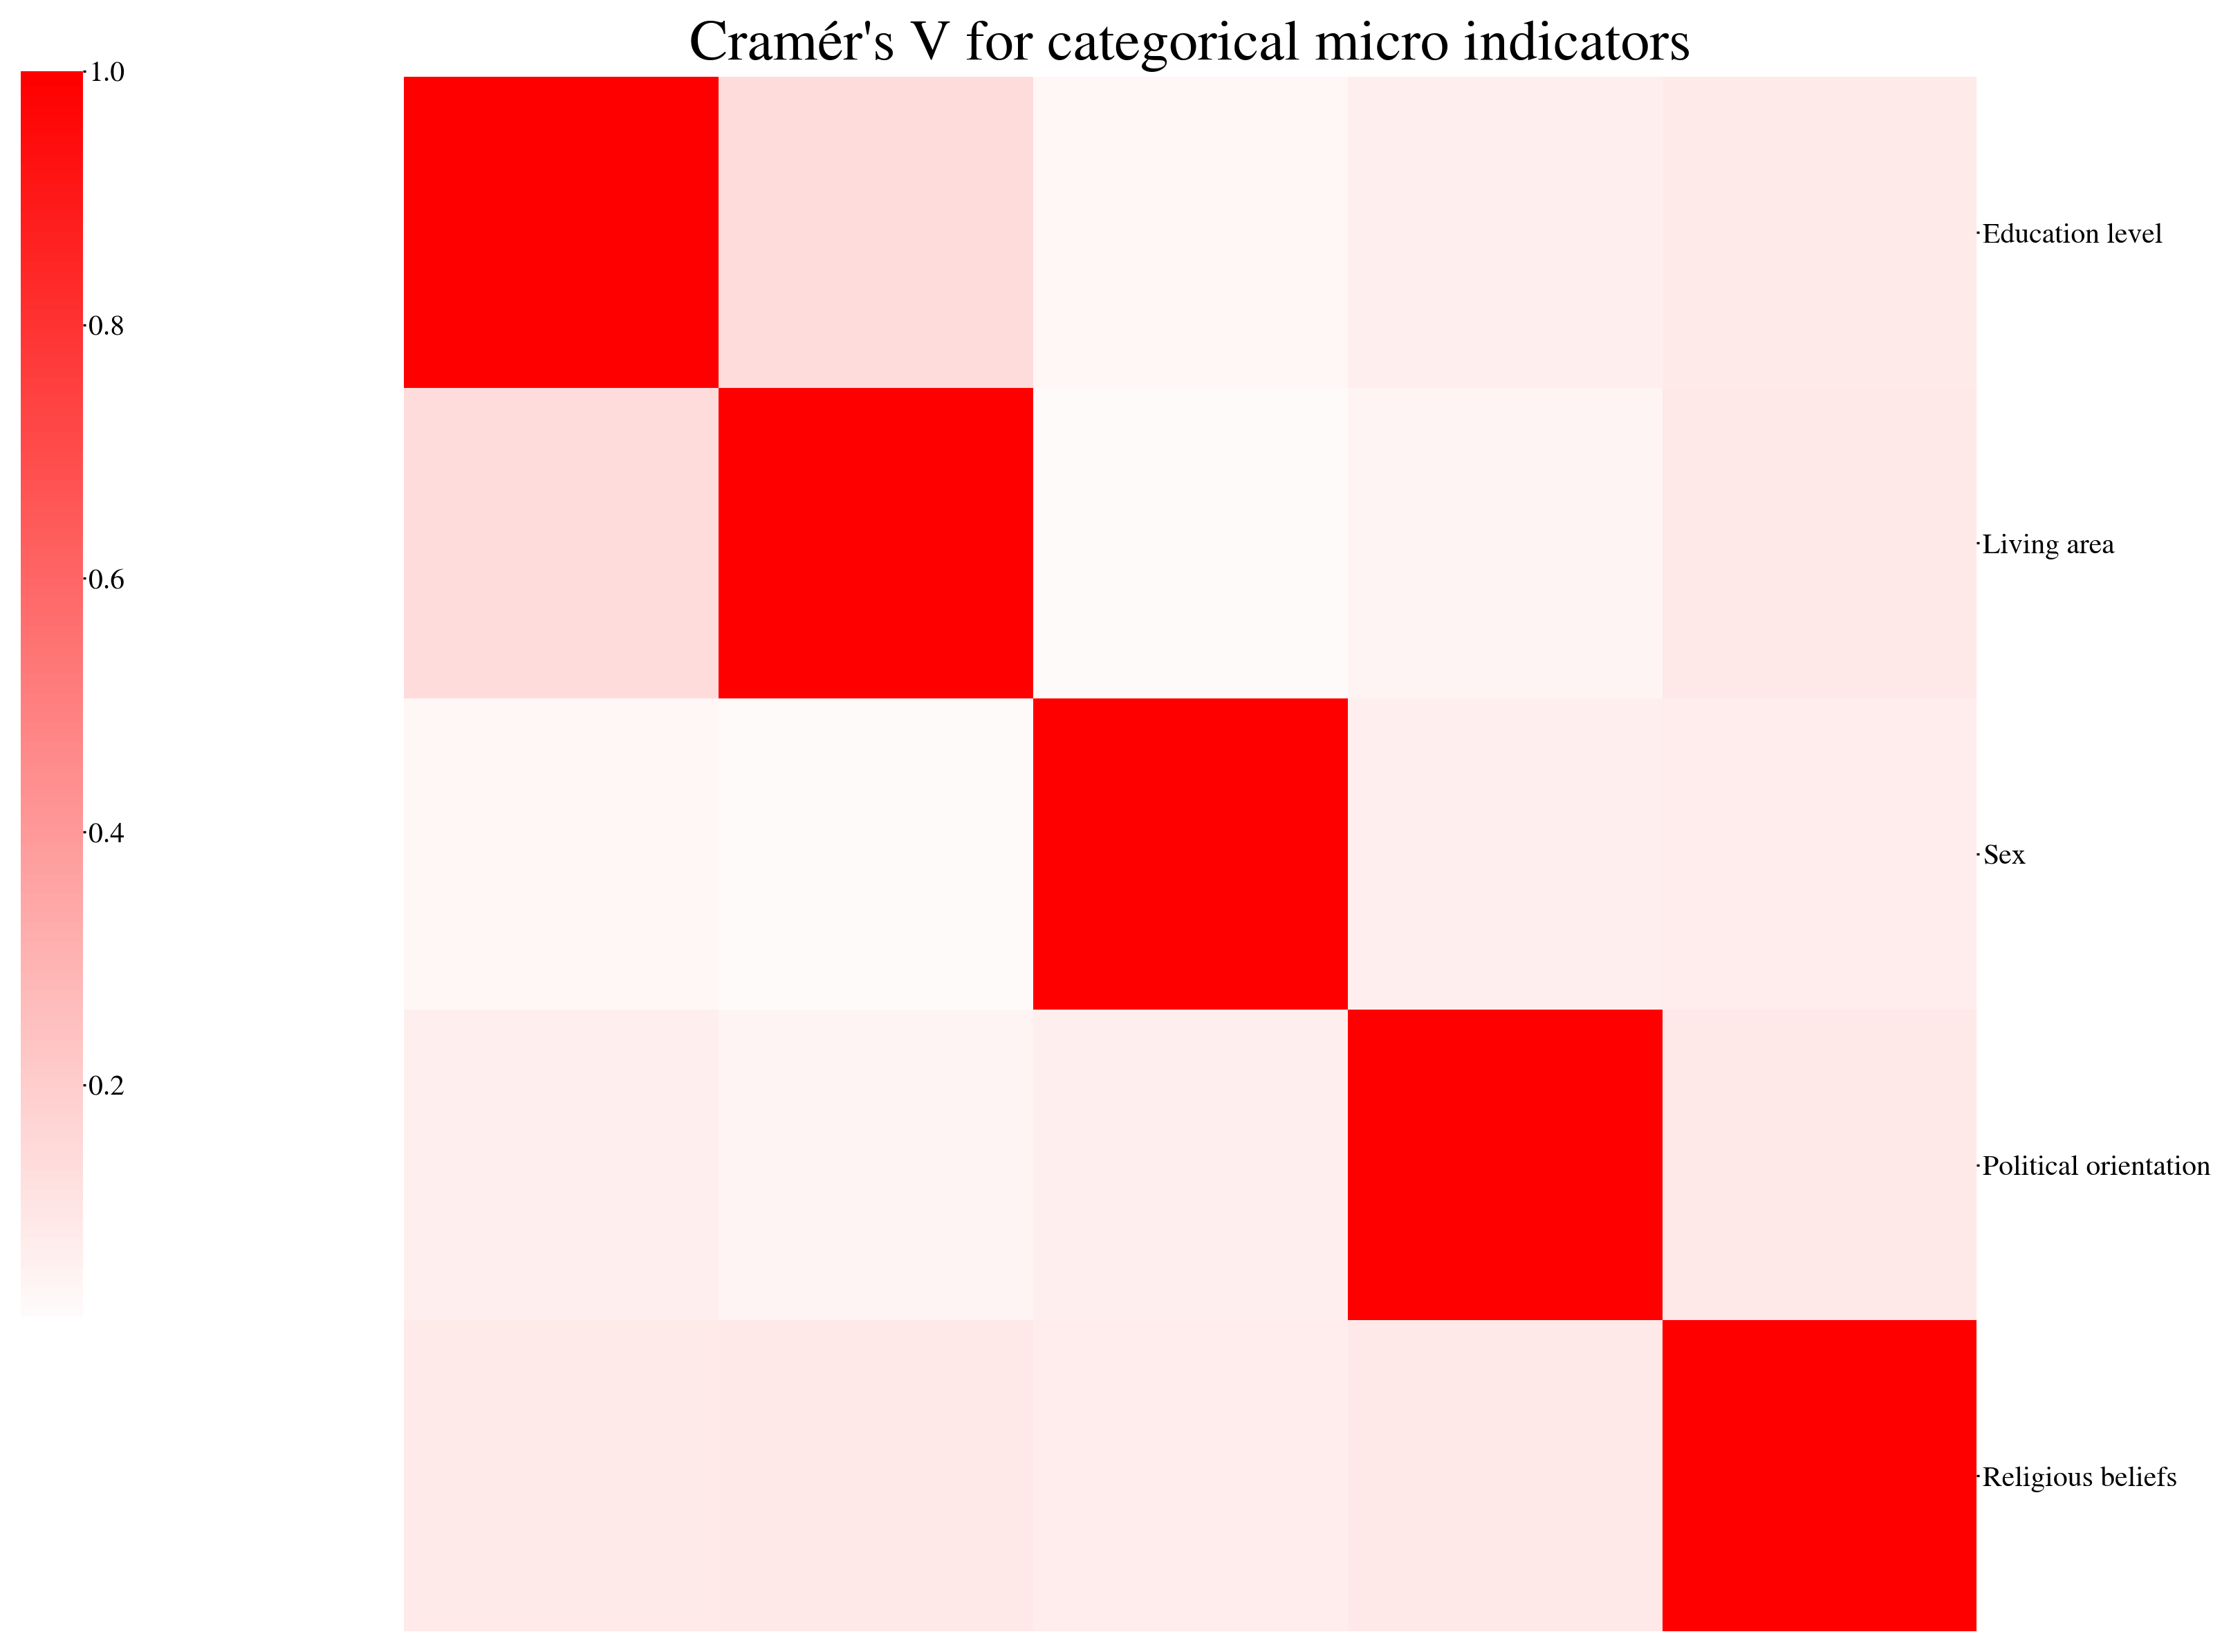

In [3]:
from scipy.stats import chi2_contingency

micro_ind_df = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle").loc[:,"Respondent Data"].select_dtypes(include="category").dropna()
corr_matrix = pd.DataFrame(1, index=micro_ind_df.columns.values, columns=micro_ind_df.columns.values, dtype="float")

for i in corr_matrix.index:
    for j in corr_matrix.columns:
        if i != j:
            crosstab = pd.crosstab(micro_ind_df[i], micro_ind_df[j])
            chi2 = chi2_contingency(crosstab)[0]
            n = crosstab.sum().sum()
            phi2 = chi2/n
            r,k = crosstab.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            corr_matrix.loc[i,j] = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

clm = sns.clustermap(corr_matrix, center=0, cmap="bwr", cbar_pos=(0.02, 0.2, 0.03, 0.6), method="ward")
clm.ax_row_dendrogram.set_visible(False)
clm.ax_col_dendrogram.set_visible(False)
clm.tick_params(size=1, pad=1, labelsize=6)
clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_ymajorticklabels(), fontsize=10, rotation=0)
clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)

clm.ax_heatmap.set_title("Cramér's V for categorical micro indicators", fontsize=20);
clm.ax_heatmap.set_xticks([])
clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_ylabel("")

#clm.savefig("../Figures/indicators_corr_categorical.pdf", format="pdf")

/var/folders/mv/3xxn6x011nj1xbbrht5z6r1m0000gn/T/ipykernel_1406/2526299267.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)


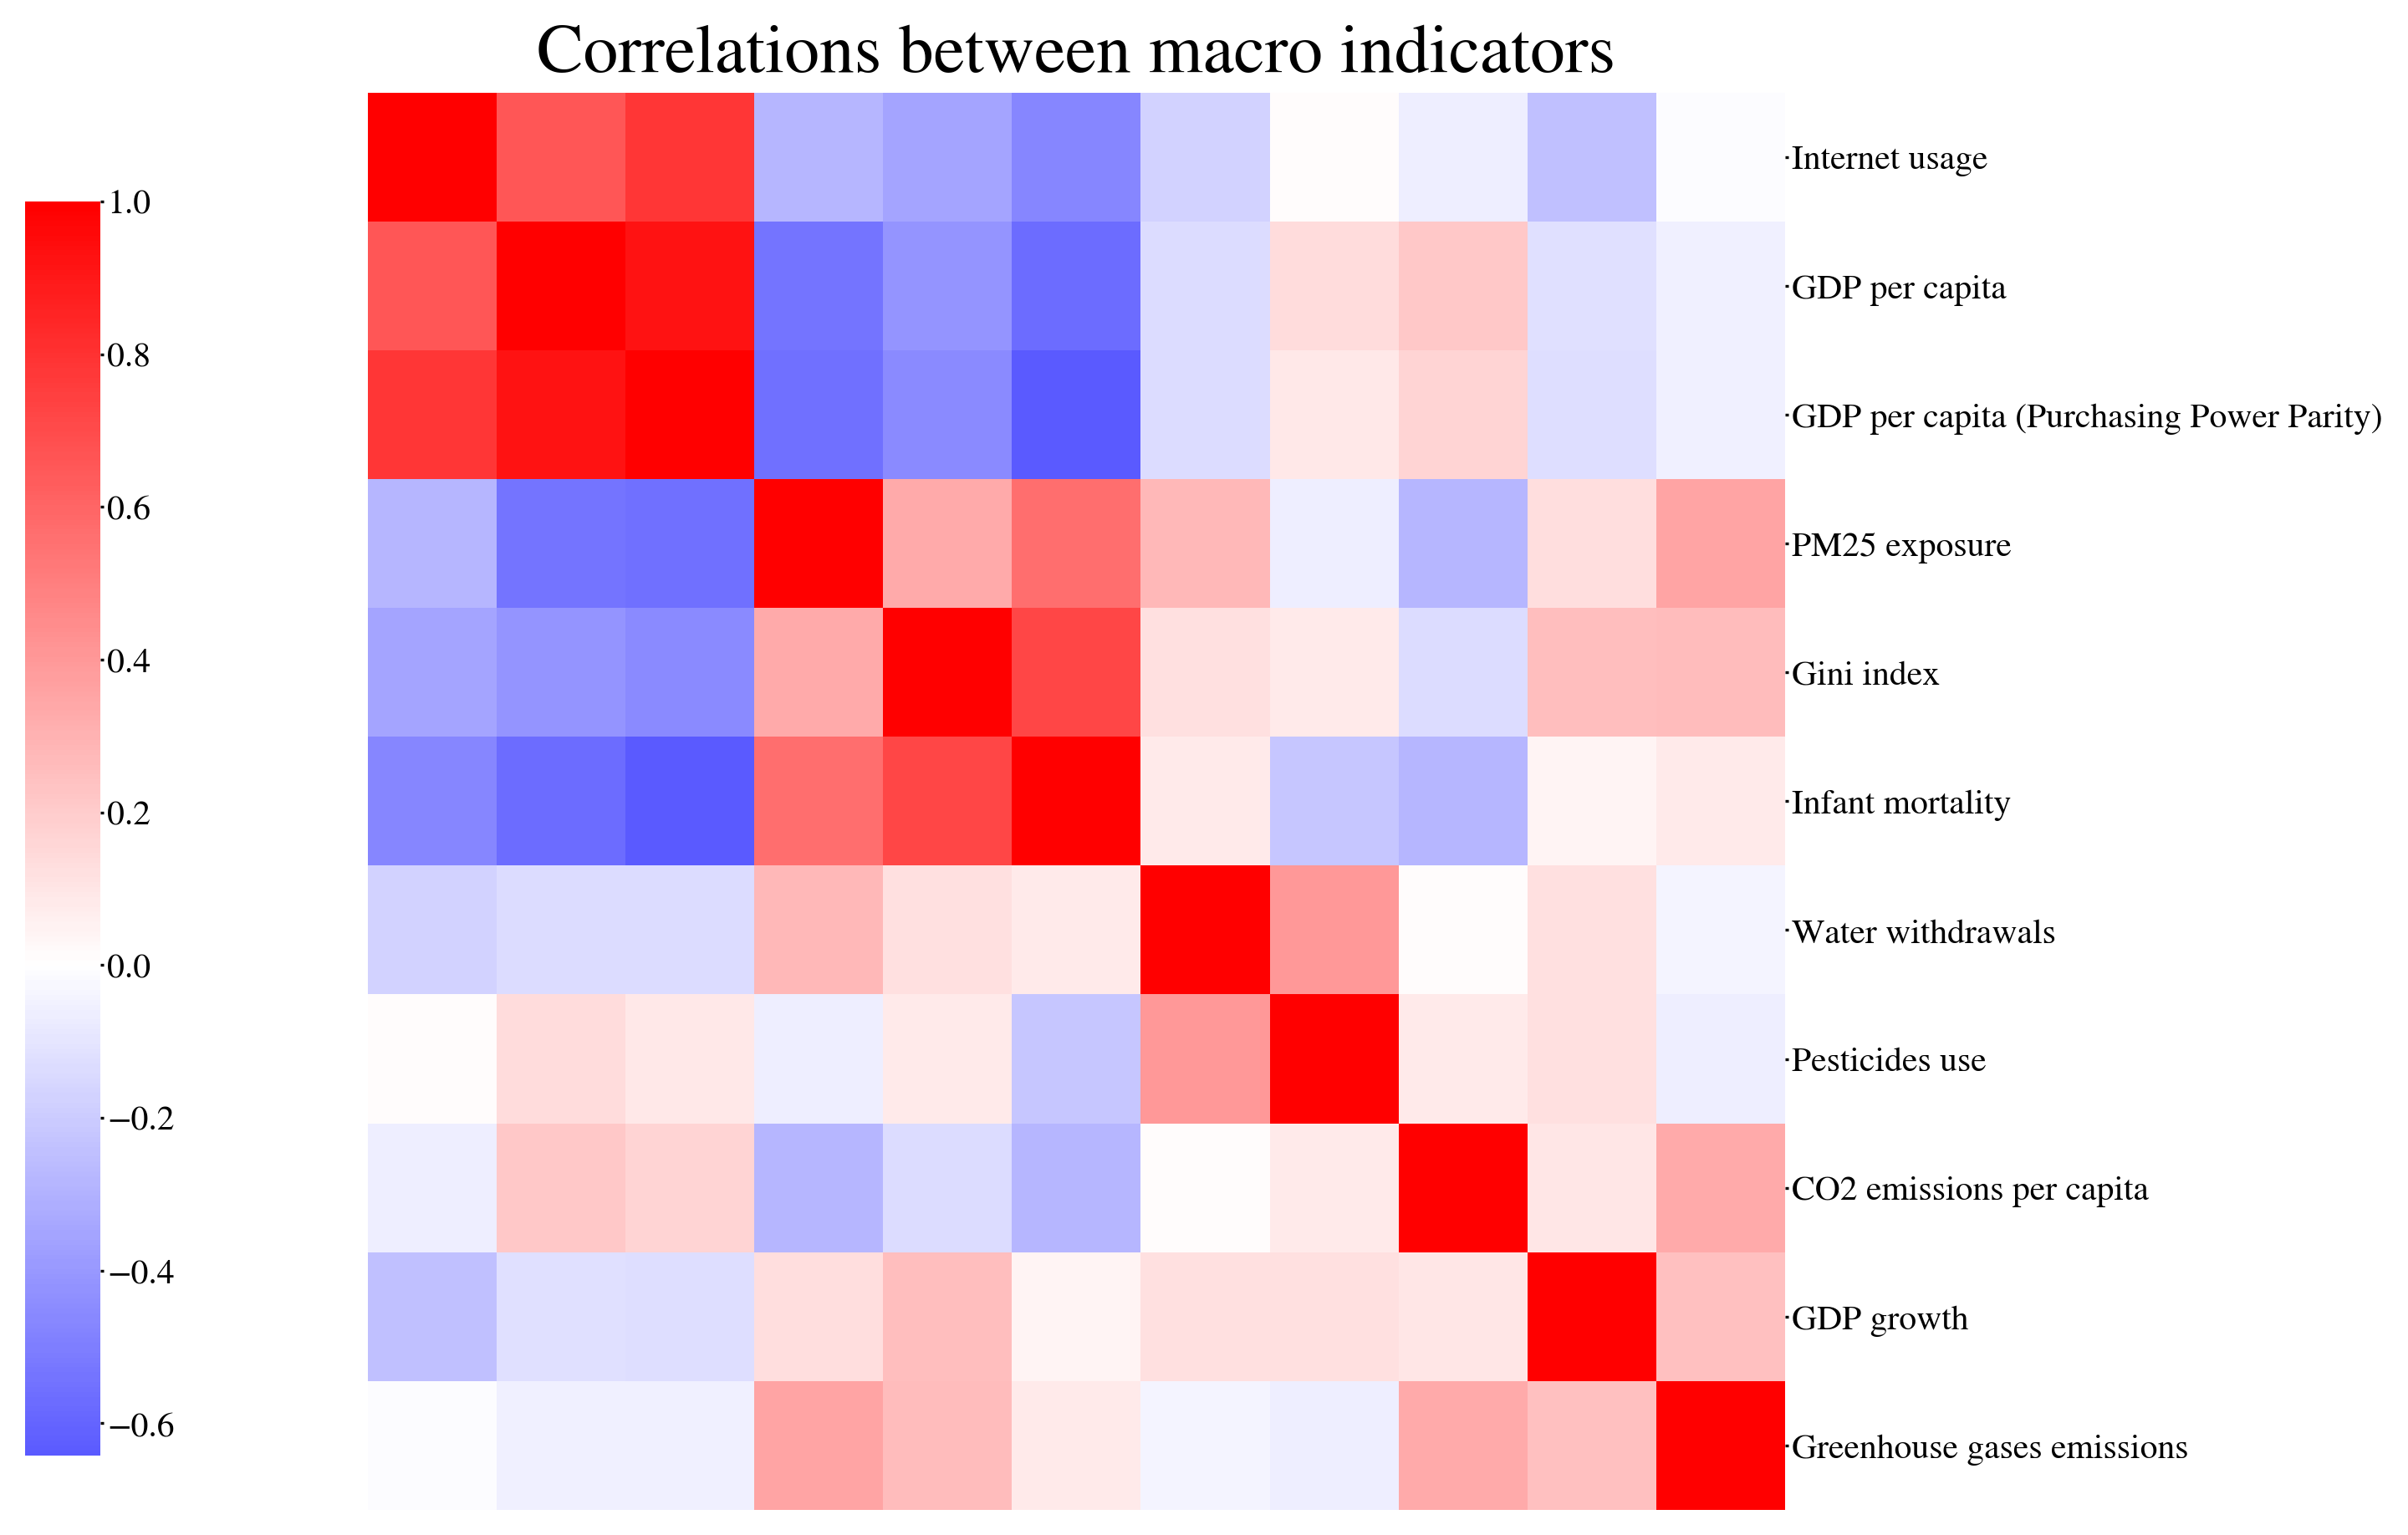

In [3]:
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

macro_indicators_dict = {(ind[:-7]) : pd.read_pickle(f"../Processed_Data/indicators/{ind}") for ind in os.listdir("../Processed_Data/indicators") if ind[-7:] == ".pickle"}
macro_ind_df = pd.concat([pd.DataFrame.from_records([data_issp.index.droplevel("Unique ID").unique().map(lambda idx: indicator.loc[idx[1], idx[0]]) for indicator in macro_indicators_dict.values()], index=macro_indicators_dict.keys(), columns=data_issp.index.droplevel("Unique ID").unique()).T], keys=["Country-wide indicators"], names=["Variable Type", "Variable Name"], axis=1)

#rename macro indicators columns
newcols = {
    "GHG_emissions"     : "Greenhouse gases emissions",
    "PM25_exposure"     : "PM25 exposure",
    "GDP_growth"        : "GDP growth",
    "gini_index"        : "Gini index",
    "GDP_pcap_ppp"      : "GDP per capita (Purchasing Power Parity)",
    "water_withdrawals" : "Water withdrawals",
    "pesticides_use"    : "Pesticides use",
    "GDP_pcap"          : "GDP per capita",
    "internet_usage"    : "Internet usage",
    "CO2_emissions_per_capita" : "CO2 emissions per capita",
    "infant_mortality"  : "Infant mortality"
          }

newcols = {("Country-wide indicators", key) : ("Country-wide indicators", value) for key, value in newcols.items()}

macro_ind_df.columns = macro_ind_df.columns.map(lambda x: newcols.get(x,x))

corr_matrix = macro_ind_df.corr()
corr_matrix.columns = corr_matrix.columns.droplevel(0)
corr_matrix.index = corr_matrix.index.droplevel(0)

clm = sns.clustermap(corr_matrix, cmap="bwr", center=0, cbar_pos=(0.02, 0.3, 0.03, 0.5), method="ward")
clm.ax_row_dendrogram.set_visible(False)
clm.ax_col_dendrogram.set_visible(False)
clm.tick_params(size=1, pad=1, labelsize=6)
clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_ymajorticklabels(), fontsize=10)
clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)

clm.ax_heatmap.set_title("Correlations between macro indicators", fontsize=20);
clm.ax_heatmap.set_xticks([])
clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_ylabel("")

#clm.savefig("../Figures/indicators_corr_macro.pdf", format="pdf")

___
# Trends by year

In [3]:
# get full dataset
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

# convert values to numerical data
conv_dict = {
    "Questions" : {
        "Strongly Disagree" : -2,
        "Disagree" : -1,
        "Neither Agree nor Disagree" : 0,
        "Agree" : 1,
        "Strongly Agree" : 2,

        "Yes" : 1,
        "No" : -1,

        'Extremely dangerous': 2,
        'Very dangerous': 1,
        'Somewhat dangerous': 0,
        'Not very dangerous': -1,
        'Not dangerous at all': -2,

        "Always" : 3,
        "Often" : 2,
        "Sometimes" : 1,
        "Never" : 0,

        'Very willing': 2,
        'Fairly willing': 1,
        'Neither willing nor unwilling': 0,
        'Fairly unwilling': -1,
        'Very unwilling': -2
    }
}

#convert questions values to numerical
data_quest = data_issp.loc[:,("Questions", slice(None))].map(lambda x: conv_dict["Questions"].get(x, x)).astype(float)

#respondent data
data_resp = data_issp.loc[:,("Respondent Data", slice(None))]

#cluster questions based on topic
clusters = {
    #TOPIC 1: awareness of the environmental consequences of societies’ modern, industrial activities
    "Awareness" : [
        'Danger to the environment (Air pollution by cars)',
        'Danger to the environment (Air pollution by industry)',
        'Danger to the environment (Pesticides and chemicals in farming)',
        'Danger to the environment (River, lake and stream pollution)',
        'Danger to the environment (Rise in the world’s temperature)',
        'Danger to the environment (Nuclear power stations)'
    ],

    #TOPIC 2: willingness to sacrifice personally in some manner (e.g. time, money) for the environment
    "Will to make sacrifices" : [
        'Willingness to Make Trade-Offs for Environment (Pay much higher prices)',
        'Willingness to Make Trade-Offs for Environment (Pay much higher taxes)',
        'Willingness to Make Trade-Offs for Environment (Cut your standard of living)',
        'Member of a group to preserve environment',
        'In the last five years, signed a petition',
        'In the last five years, given money',
        'In the last five years, participated in an environmental demonstration',
        'I do what is right even when it costs money and takes time'
    ],
    
    #TOPIC 3: importance of addressing environmental problems and of collective effort for resolving environmental
    #issues and how environmental issues inter- sect with economic issues, science and progress
    # NB!! answers are rescaled so that higher scores reflect pro-environment responses
    "Efficacy of environmental action" : [
        'We worry too much about harming environment',
        'We worry too much about future environment',
        'Science solves environmental problems',
        'Too difficult to do much about environment'
    ]
        
}

#rescale
data_to_cluster = data_quest.apply(lambda x: x if x.name[1] not in clusters["Efficacy of environmental action"] else -x)
data_quest_clustered = pd.concat([pd.concat([data_to_cluster.loc[:, ("Questions", clusters[topic])].sum(axis=1) for topic in clusters], axis=1, keys=clusters.keys())], keys=["Environmental concern dimension"],  names=["Variable Type", "Variable Name"], axis=1)


#get country-wide indicators columns
macro_indicators_dict = {(ind[:-7]) : pd.read_pickle(f"../Processed_Data/indicators/{ind}") for ind in os.listdir("../Processed_Data/indicators") if ind[-7:] == ".pickle"}
data_indic = pd.concat([pd.DataFrame.from_records([data_issp.index.map(lambda idx: indicator.loc[idx[1], idx[0]]) for indicator in macro_indicators_dict.values()], index=macro_indicators_dict.keys(), columns=data_issp.index).T], keys=["Country-wide indicators"], names=["Variable Type", "Variable Name"], axis=1)


#merge into single dataframes
data_issp_clustered = pd.concat([data_resp, data_indic, data_quest_clustered], axis=1) #clustered questions into topics
data_issp_clustered.loc[:, ("Environmental concern dimension", slice(None))]  = data_issp_clustered.loc[:, ("Environmental concern dimension", slice(None))]  / [12,11,8] #rescale so that y  [-1,1]

del(data_issp, data_resp, data_quest, data_to_cluster, data_quest_clustered, data_indic, conv_dict)

#rename macro indicators columns
newcols = {
    "GHG_emissions"     : "Greenhouse gases emissions",
    "PM25_exposure"     : "PM25 exposure",
    "GDP_growth"        : "GDP growth",
    "gini_index"        : "Gini index",
    "GDP_pcap_ppp"      : "GDP per capita (Purchasing Power Parity)",
    "water_withdrawals" : "Water withdrawals",
    "pesticides_use"    : "Pesticides use",
    "GDP_pcap"          : "GDP per capita",
    "internet_usage"    : "Internet usage",
    "CO2_emissions_per_capita" : "CO2 emissions per capita",
    "infant_mortality"  : "Infant mortality"
          }

newcols = {("Country-wide indicators", key) : ("Country-wide indicators", value) for key, value in newcols.items()}

data_issp_clustered.columns = data_issp_clustered.columns.map(lambda x: newcols.get(x,x))

In [34]:
data_issp_clustered.loc[:,"Environmental concern dimension"].groupby(["Year", "Country"]).mean().reset_index().pivot(columns="Year", index="Country")

Variable Name  Awareness                                \
Year                1993      2000      2010      2020   
Country                                                  
Argentina            NaN       NaN  0.534956       NaN   
Australia       0.376522       NaN  0.272610  0.322799   
Austria              NaN  0.441807  0.416830  0.524319   
Belgium              NaN       NaN  0.240003       NaN   
Bulgaria        0.389828  0.310135  0.460784       NaN   
Canada          0.412122  0.411061  0.385448       NaN   
Chile                NaN  0.503271  0.639276       NaN   
China                NaN       NaN  0.443300  0.323234   
Croatia              NaN       NaN  0.528650  0.478583   
Czechia         0.388557  0.359928  0.301354       NaN   
Denmark              NaN  0.279545  0.254598  0.245409   
Finland              NaN  0.195135  0.232177  0.217092   
France               NaN       NaN  0.346686  0.351096   
Germany         0.460193  0.415945  0.414120  0.475078   
Hungary         0.245287       NaN       NaN  0.395188   
Iceland              NaN       NaN  0.259712  0.336957   
India                NaN       NaN       NaN  0.349402   
Ireland         0.419192  0.372294       NaN       NaN   
Israel          0.323734  0.349931  0.443942       NaN   
Italy           0.456417       NaN       NaN  0.420694   
Japan           0.348404  0.432345  0.356032  0.357143   
Latvia               NaN  0.365750  0.301583       NaN   
Lithuania            NaN       NaN  0.437765  0.404444   
Mexico               NaN  0.397319  0.521788       NaN   
Netherlands     0.200324  0.196240  0.211447       NaN   
New Zealand     0.356412  0.417566  0.288965  0.414904   
Norway          0.254008  0.180211  0.185781  0.218612   
Philippines     0.406319  0.633056  0.526111  0.512056   
Poland          0.340392       NaN       NaN       NaN   
Portugal             NaN  0.613500  0.489889       NaN   
Russia          0.475574  0.583627  0.553377  0.540430   
Slovakia             NaN       NaN  0.436799  0.452205   
Slovenia        0.398902  0.365908  0.419054  0.418708   
South Africa         NaN       NaN  0.437687  0.359558   
South Korea          NaN       NaN  0.354801  0.404219   
Spain           0.372034  0.497042  0.472754  0.427980   
Sweden               NaN  0.245626  0.247319  0.274640   
Switzerland          NaN  0.364811  0.326595  0.340187   
Thailand             NaN       NaN       NaN  0.492657   
Turkiye              NaN       NaN  0.606757       NaN   
United Kingdom  0.316157  0.336682  0.184267       NaN   
United States   0.297313  0.278932  0.312179  0.327062   

Variable Name  Will to make sacrifices                                \
Year                              1993      2000      2010      2020   
Country                                                                
Argentina                          NaN       NaN -0.489300       NaN   
Australia                    -0.114569       NaN -0.260628 -0.161607   
Austria                            NaN -0.111591 -0.321260 -0.166534   
Belgium                            NaN       NaN -0.323913       NaN   
Bulgaria                     -0.332129 -0.566993 -0.581347       NaN   
Canada                       -0.110120 -0.256502 -0.197970       NaN   
Chile                              NaN -0.361036 -0.358129       NaN   
China                              NaN       NaN -0.260216 -0.268165   
Croatia                            NaN       NaN -0.563186 -0.512364   
Czechia                      -0.398643 -0.404487 -0.515279       NaN   
Denmark                            NaN -0.234544 -0.194357 -0.227652   
Finland                            NaN -0.325559 -0.327078 -0.290397   
France                             NaN       NaN -0.314006 -0.229007   
Germany                      -0.240827 -0.294107 -0.280222 -0.200406   
Hungary                      -0.473319       NaN       NaN -0.486241   
Iceland                            NaN       NaN -0.353270 -0.202055   
India                

In [70]:
regions = {
    'Australia': 'Asia/South America/Africa',
    'Bulgaria': 'Europe/North America',
    'Canada': 'Europe/North America',
    'Czechia': 'Europe/North America',
    'Germany': 'Europe/North America',
    'Hungary': 'Europe/North America',
    'Ireland': 'Europe/North America',
    'Israel': 'Asia/South America/Africa',
    'Italy': 'Europe/North America',
    'Japan': 'Asia/South America/Africa',
    'Netherlands': 'Europe/North America',
    'New Zealand': 'Europe/North America',
    'Norway': 'Europe/North America',
    'Philippines': 'Asia/South America/Africa',
    'Poland': 'Europe/North America',
    'Russia': 'Asia/South America/Africa',
    'Slovenia': 'Europe/North America',
    'Spain': 'Europe/North America',
    'United Kingdom': 'Europe/North America',
    'United States': 'Europe/North America',
    'Austria': 'Europe/North America',
    'Chile': 'Asia/South America/Africa',
    'Denmark': 'Europe/North America',
    'Finland': 'Europe/North America',
    'Latvia': 'Europe/North America',
    'Mexico': 'Asia/South America/Africa',
    'Portugal': 'Europe/North America',
    'Sweden': 'Europe/North America',
    'Switzerland': 'Europe/North America',
    'Argentina': 'Asia/South America/Africa',
    'Belgium': 'Europe/North America',
    'China': 'Asia/South America/Africa',
    'Croatia': 'Europe/North America',
    'France': 'Europe/North America',
    'Iceland': 'Europe/North America',
    'Lithuania': 'Europe/North America',
    'Slovakia': 'Europe/North America',
    'South Africa': 'Asia/South America/Africa',
    'South Korea': 'Asia/South America/Africa',
    'Turkiye': 'Asia/South America/Africa',
    'India': 'Asia/South America/Africa',
    'Thailand': 'Asia/South America/Africa'
}

In [68]:
regions1 = {
    'Australia': 'Asia/Oceania',
    'Bulgaria': 'Europe',
    'Canada': 'America',
    'Czechia': 'Europe',
    'Germany': 'Europe',
    'Hungary': 'Europe',
    'Ireland': 'Europe',
    'Israel': 'Asia/Oceania',
    'Italy': 'Europe',
    'Japan': 'Asia/Oceania',
    'Netherlands': 'Europe',
    'New Zealand': 'Asia/Oceania',
    'Norway': 'Europe',
    'Philippines': 'Asia/Oceania',
    'Poland': 'Europe',
    'Russia': 'Asia/Oceania',
    'Slovenia': 'Europe',
    'Spain': 'Europe',
    'United Kingdom': 'Europe',
    'United States': 'America',
    'Austria': 'Europe',
    'Chile': 'America',
    'Denmark': 'Europe',
    'Finland': 'Europe',
    'Latvia': 'Europe',
    'Mexico': 'America',
    'Portugal': 'Europe',
    'Sweden': 'Europe',
    'Switzerland': 'Europe',
    'Argentina': 'America',
    'Belgium': 'Europe',
    'China': 'Asia/Oceania',
    'Croatia': 'Europe',
    'France': 'Europe',
    'Iceland': 'Europe',
    'Lithuania': 'Europe',
    'Slovakia': 'Europe',
    'South Africa': 'Asia/Oceania',
    'South Korea': 'Asia/Oceania',
    'Turkiye': 'Asia/Oceania',
    'India': 'Asia/Oceania',
    'Thailand': 'Asia/Oceania'
}

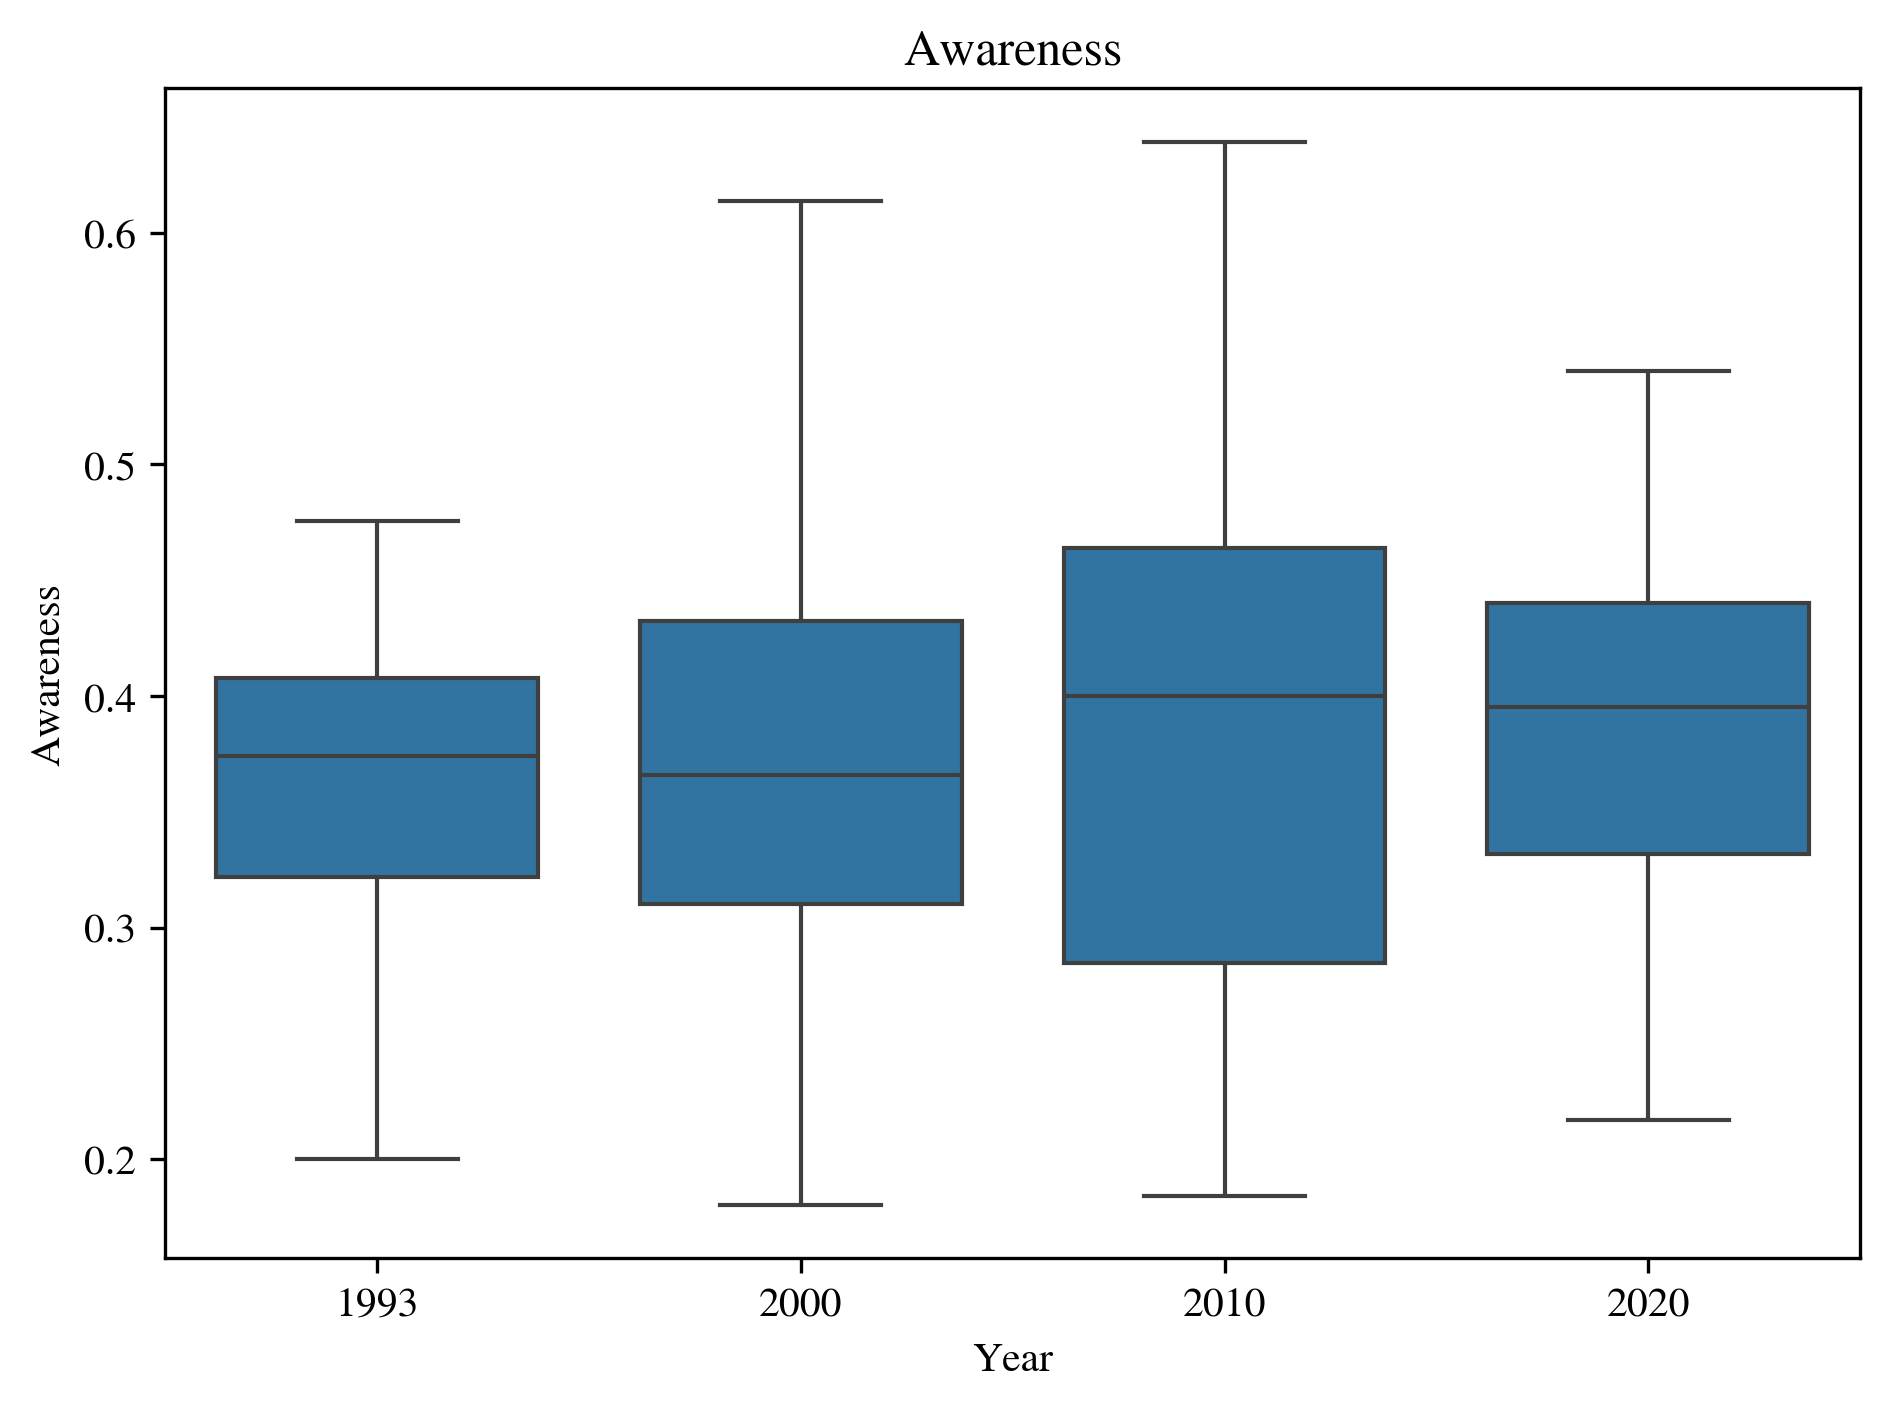

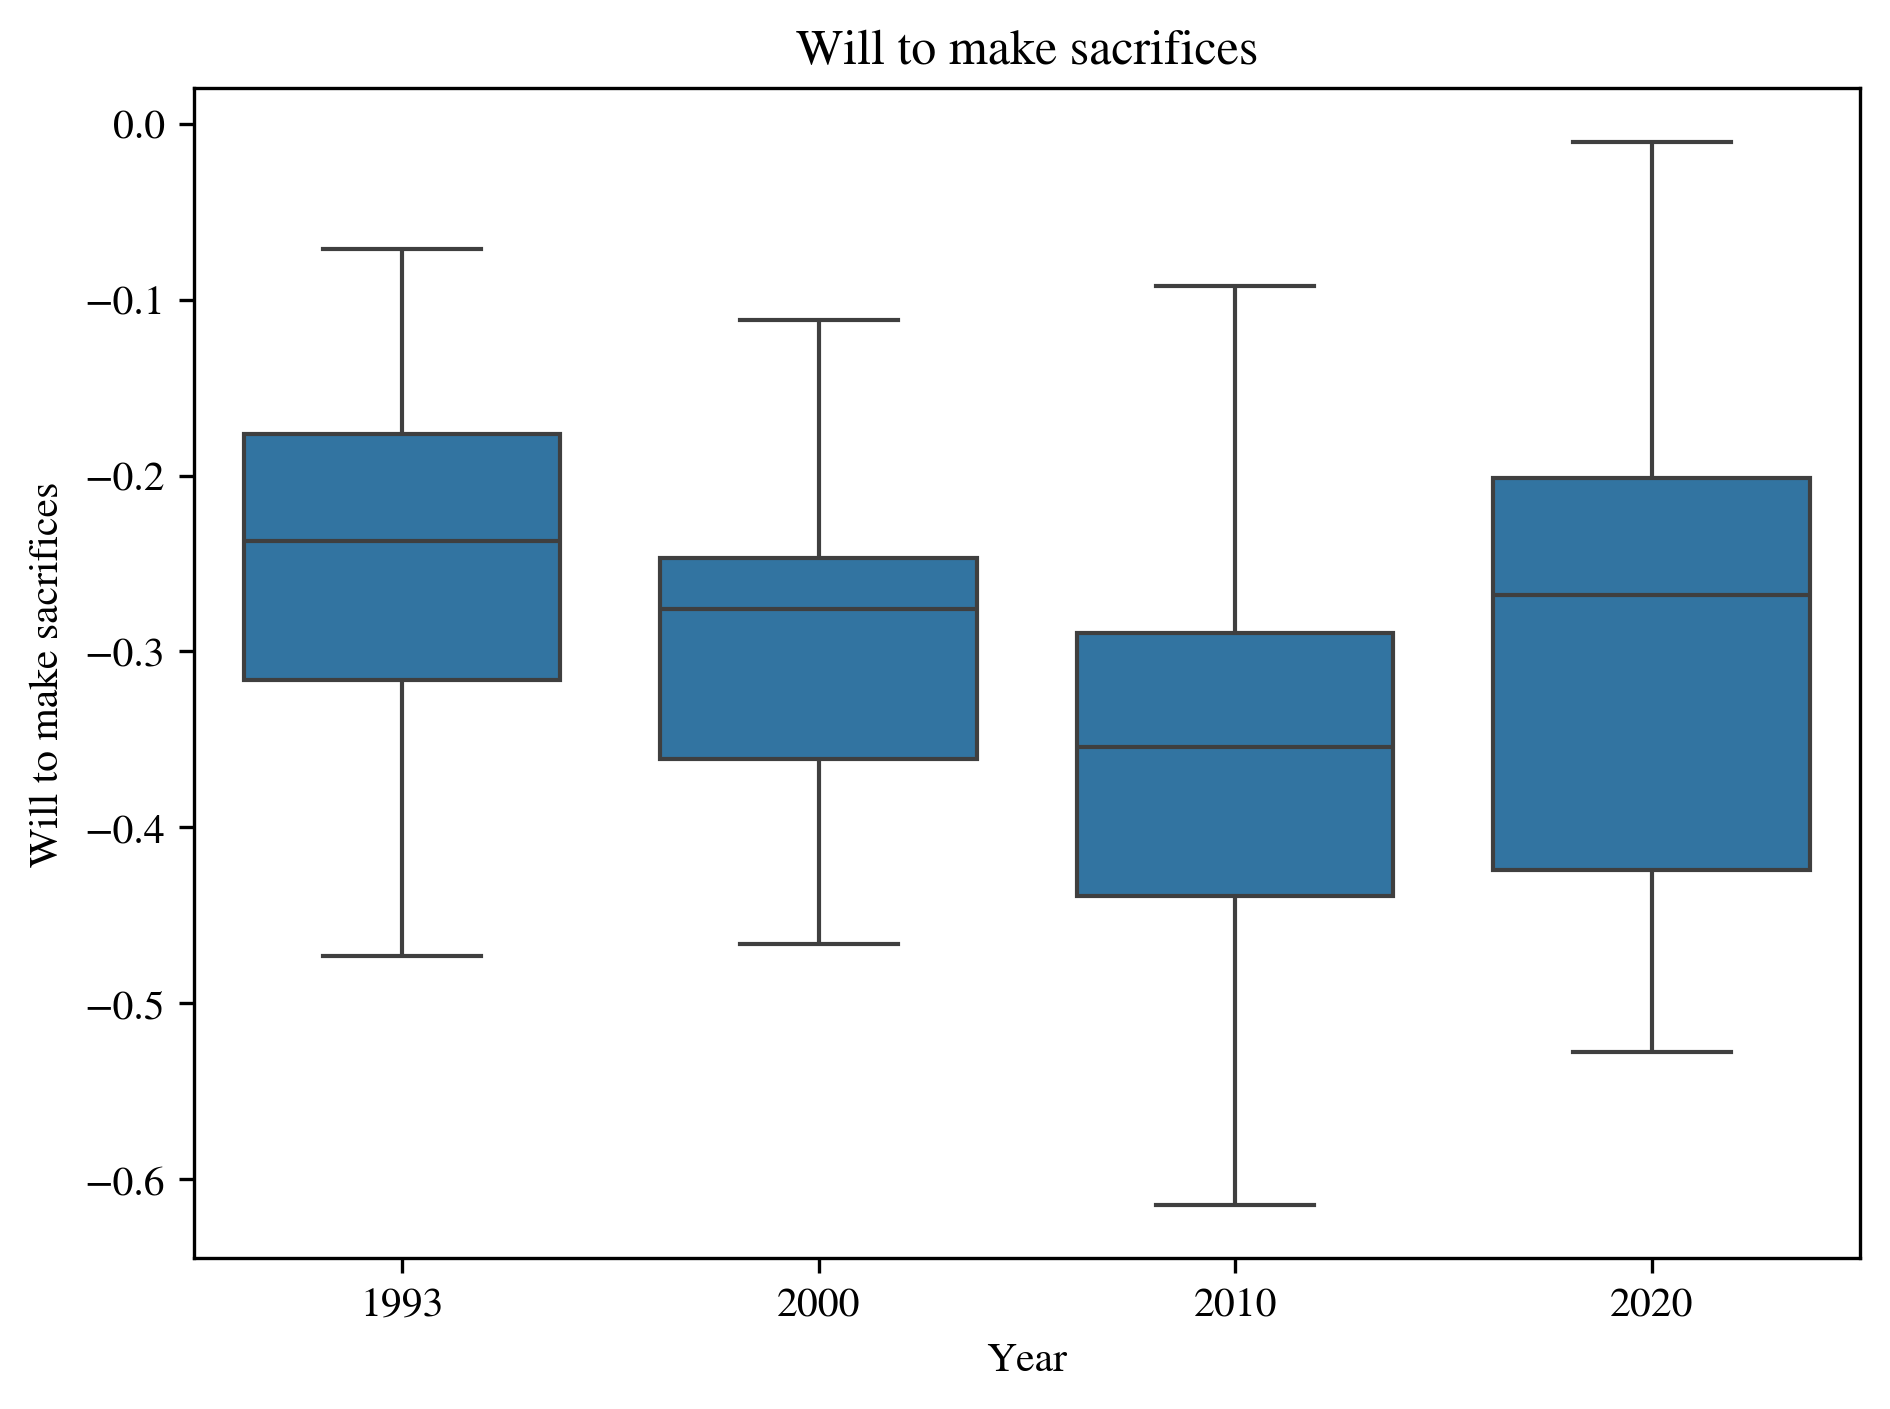

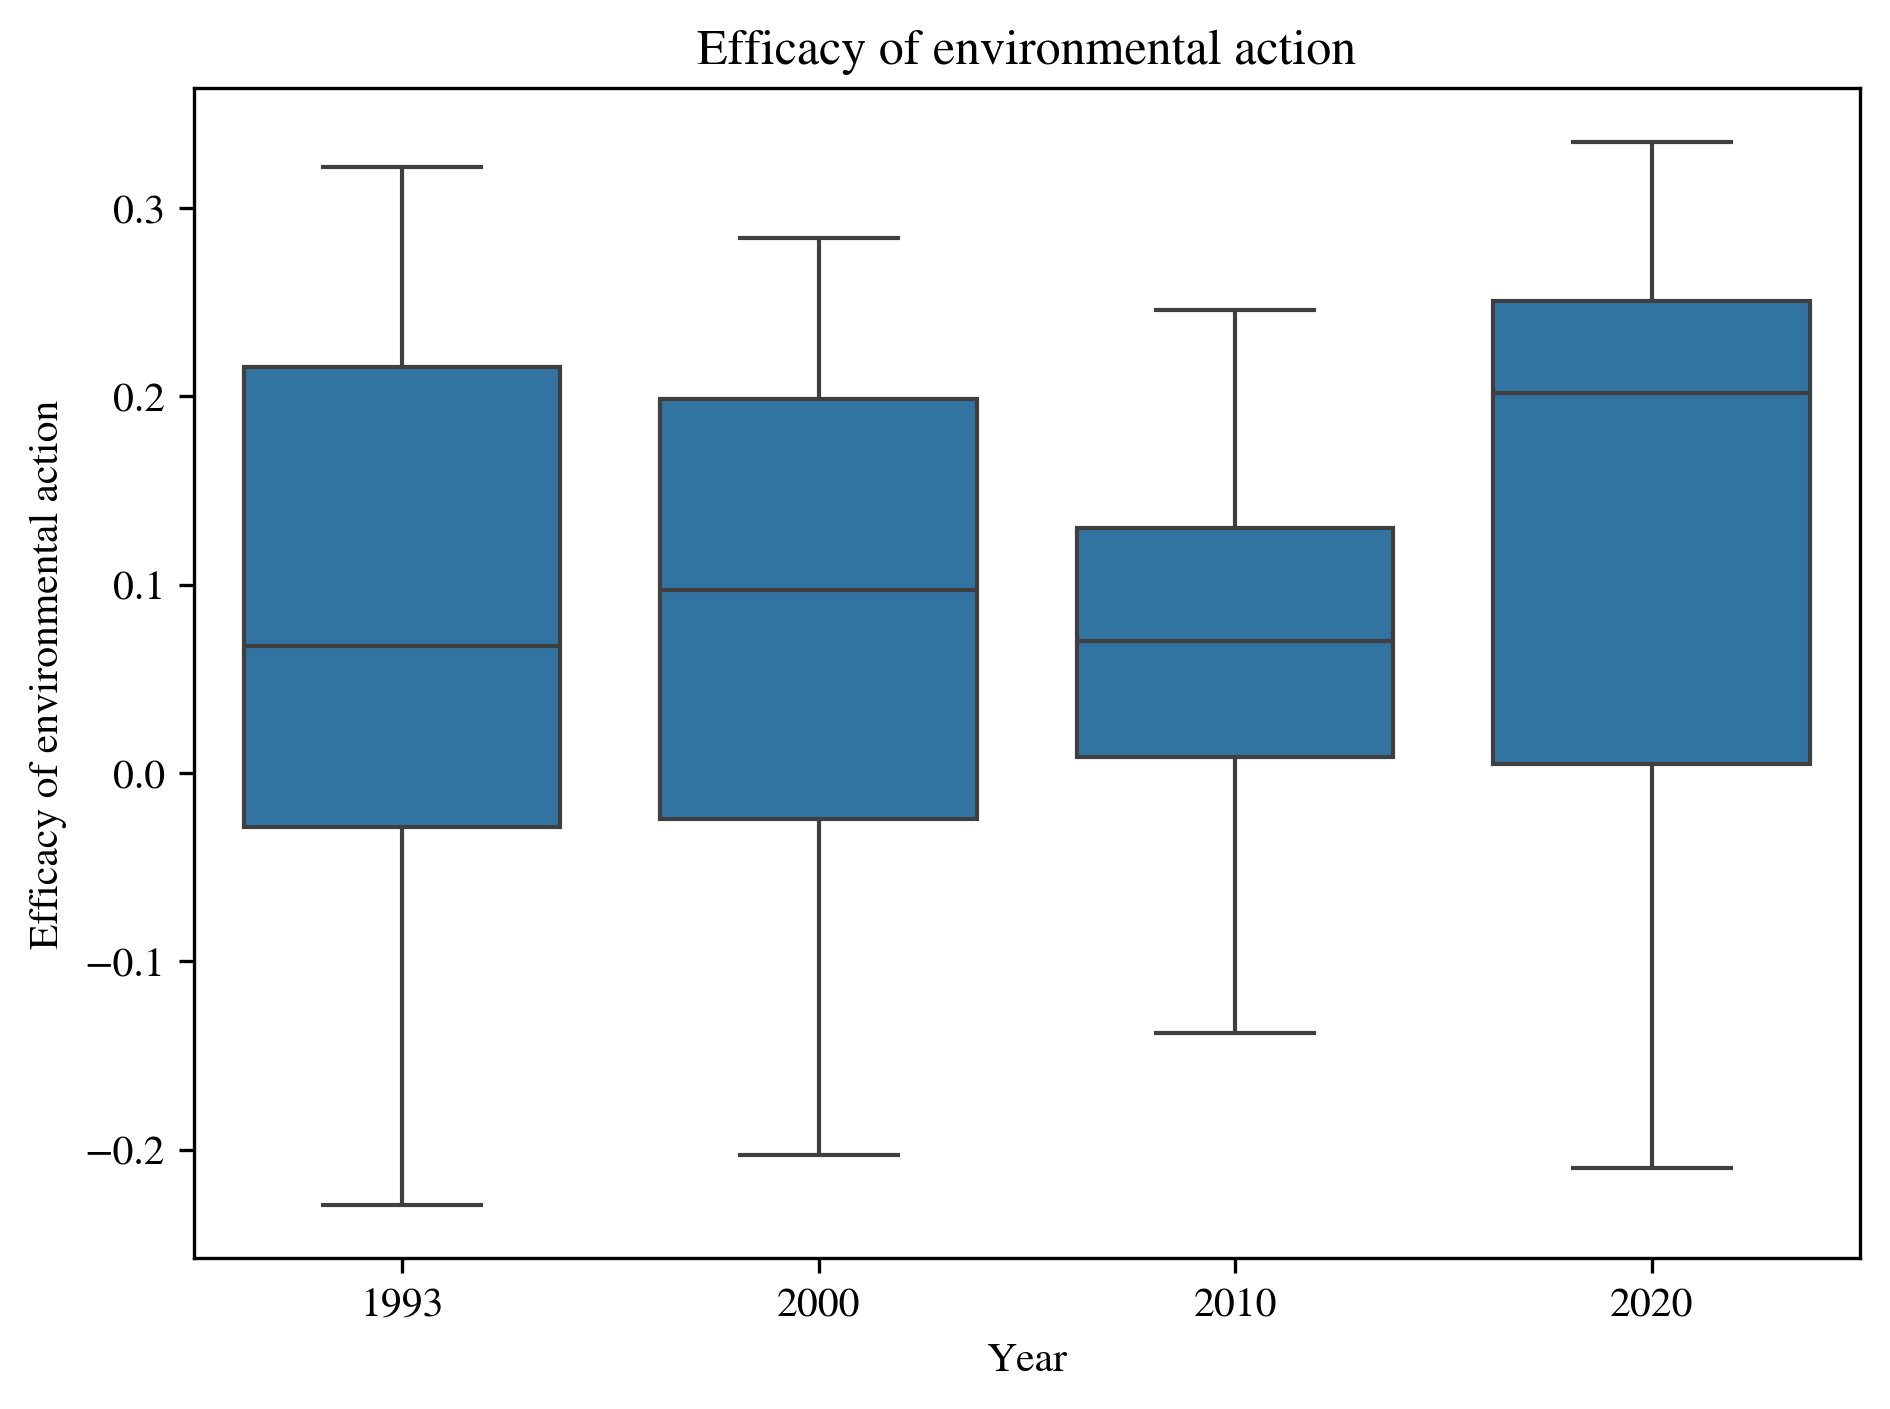

In [72]:
for topic in data_issp_clustered.loc[:,"Environmental concern dimension"].columns:
    fig, ax = plt.subplots()
    ax.set_title(f"{topic}")
    df = data_issp_clustered.loc[:,"Environmental concern dimension"].groupby(["Year", "Country"]).mean().reset_index()
    df["Region"] = df["Country"].map(regions)
    sns.boxplot(data=df, x="Year", y=topic, gap=0.05, showfliers=False, ax=ax)
    plt.tight_layout()
    #plt.savefig(f"../Figures/{topic}_vs_years.pdf", format="pdf")

___
# Trends by Respondent Data and Country-Wide Indicators

In [3]:
# get full dataset
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

# convert values to numerical data
conv_dict = {
    "Questions" : {
        "Strongly Disagree" : -2,
        "Disagree" : -1,
        "Neither Agree nor Disagree" : 0,
        "Agree" : 1,
        "Strongly Agree" : 2,

        "Yes" : 1,
        "No" : -1,

        'Extremely dangerous': 2,
        'Very dangerous': 1,
        'Somewhat dangerous': 0,
        'Not very dangerous': -1,
        'Not dangerous at all': -2,

        "Always" : 3,
        "Often" : 2,
        "Sometimes" : 1,
        "Never" : 0,

        'Very willing': 2,
        'Fairly willing': 1,
        'Neither willing nor unwilling': 0,
        'Fairly unwilling': -1,
        'Very unwilling': -2
    }
}

#convert questions values to numerical
data_quest = data_issp.loc[:,("Questions", slice(None))].map(lambda x: conv_dict["Questions"].get(x, x)).astype(float)

#respondent data
data_resp = data_issp.loc[:,("Respondent Data", slice(None))]

#cluster questions based on topic
clusters = {
    #TOPIC 1: awareness of the environmental consequences of societies’ modern, industrial activities
    "Awareness" : [
        'Danger to the environment (Air pollution by cars)',
        'Danger to the environment (Air pollution by industry)',
        'Danger to the environment (Pesticides and chemicals in farming)',
        'Danger to the environment (River, lake and stream pollution)',
        'Danger to the environment (Rise in the world’s temperature)',
        'Danger to the environment (Nuclear power stations)'
    ],

    #TOPIC 2: willingness to sacrifice personally in some manner (e.g. time, money) for the environment
    "Will to make sacrifices" : [
        'Willingness to Make Trade-Offs for Environment (Pay much higher prices)',
        'Willingness to Make Trade-Offs for Environment (Pay much higher taxes)',
        'Willingness to Make Trade-Offs for Environment (Cut your standard of living)',
        'Member of a group to preserve environment',
        'In the last five years, signed a petition',
        'In the last five years, given money',
        'In the last five years, participated in an environmental demonstration',
        'I do what is right even when it costs money and takes time'
    ],
    
    #TOPIC 3: importance of addressing environmental problems and of collective effort for resolving environmental
    #issues and how environmental issues inter- sect with economic issues, science and progress
    # NB!! answers are rescaled so that higher scores reflect pro-environment responses
    "Efficacy of environmental action" : [
        'We worry too much about harming environment',
        'We worry too much about future environment',
        'Science solves environmental problems',
        'Too difficult to do much about environment'
    ]
        
}

#rescale
data_to_cluster = data_quest.apply(lambda x: x if x.name[1] not in clusters["Efficacy of environmental action"] else -x)
data_quest_clustered = pd.concat([pd.concat([data_to_cluster.loc[:, ("Questions", clusters[topic])].sum(axis=1) for topic in clusters], axis=1, keys=clusters.keys())], keys=["Environmental concern dimension"],  names=["Variable Type", "Variable Name"], axis=1)


#get country-wide indicators columns
macro_indicators_dict = {(ind[:-7]) : pd.read_pickle(f"../Processed_Data/indicators/{ind}") for ind in os.listdir("../Processed_Data/indicators") if ind[-7:] == ".pickle"}
data_indic = pd.concat([pd.DataFrame.from_records([data_issp.index.map(lambda idx: indicator.loc[idx[1], idx[0]]) for indicator in macro_indicators_dict.values()], index=macro_indicators_dict.keys(), columns=data_issp.index).T], keys=["Country-wide indicators"], names=["Variable Type", "Variable Name"], axis=1)


#merge into single dataframes
data_issp_clustered = pd.concat([data_resp, data_indic, data_quest_clustered], axis=1) #clustered questions into topics
data_issp_clustered.loc[:, ("Environmental concern dimension", slice(None))]  = data_issp_clustered.loc[:, ("Environmental concern dimension", slice(None))]  / [12,11,8] #rescale so that y  [-1,1]

del(data_issp, data_resp, data_quest, data_to_cluster, data_quest_clustered, data_indic, conv_dict)

#rename macro indicators columns
newcols = {
    "GHG_emissions"     : "Greenhouse gases emissions",
    "PM25_exposure"     : "PM25 exposure",
    "GDP_growth"        : "GDP growth",
    "gini_index"        : "Gini index",
    "GDP_pcap_ppp"      : "GDP per capita (Purchasing Power Parity)",
    "water_withdrawals" : "Water withdrawals",
    "pesticides_use"    : "Pesticides use",
    "GDP_pcap"          : "GDP per capita",
    "internet_usage"    : "Internet usage",
    "CO2_emissions_per_capita" : "CO2 emissions per capita",
    "infant_mortality"  : "Infant mortality"
          }

newcols = {("Country-wide indicators", key) : ("Country-wide indicators", value) for key, value in newcols.items()}

data_issp_clustered.columns = data_issp_clustered.columns.map(lambda x: newcols.get(x,x))

In [ ]:
#plot answers vs indicators

from statannotations.Annotator import Annotator

micro_indicators = ['Sex', 'Age', 'Education level', 'Political orientation', 'Personal income', 'Living area', 'Religious beliefs']
macro_indicators = ["CO2 emissions per capita", "PM25 exposure", "GDP per capita (Purchasing Power Parity)", "GDP growth", "Gini index", "Infant mortality", "Internet usage", "Water withdrawals", "Pesticides use"]
indicators = micro_indicators + macro_indicators

from itertools import combinations

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for year in [1993,2000,2010,2020]:
        for topic in data_issp_clustered.loc[year, "Environmental concern dimension"].columns:
            n_plots = len(indicators)
            size_x, size_y = plt.rcParams["figure.figsize"]
            fig, axs = plt.subplots(n_plots//4,4, figsize=(0.5*4*size_x, n_plots//4*size_y), sharey=True)
            fig.suptitle(f"{topic} in {year}", size=20, y=1)
            for i, indicator in enumerate(indicators):
                #print(f"Computing effect of {indicator} for {topic} in {year}", flush=True)
                ax = axs[i//4][i%4]

                if indicator == "Personal income":
                    df = data_issp_clustered.loc[year].droplevel(level=0, axis=1).loc[:,[indicator, topic]]
                    df["bins"] = pd.qcut(df.loc[:,indicator], q=5)
                    df[indicator] = df["bins"].map(lambda x: np.nan if pd.isna(x) else f"({round(x.left,1)}, {round(x.right,1)}]")
                    sns.boxplot(data=df, x=indicator, y=topic, ax=ax, showfliers=False)

                    values = df[indicator].cat.categories
                    pairs = [(values[0], values[-1])]
                    
                    annot = Annotator(ax, pairs, data=df, x=indicator, y=topic)
                    annot.configure(test='t-test_welch', text_format='star', show_test_name=False, loc='inside', comparisons_correction="Bonferroni", verbose=0)
                    annot.apply_test()
                    annot.annotate()

                  
                    del(df, annot)
                
                elif indicator == "Age":
                    df = data_issp_clustered.loc[year].droplevel(level=0, axis=1).loc[:,[indicator, topic]]
                    df["bins"] = pd.cut(df.loc[:,indicator], bins=np.linspace(10, 110, 5))
                    df[indicator] = df["bins"]
                    sns.boxplot(data=df, x=indicator, y=topic, ax=ax, showfliers=False)

                    values = df[indicator].cat.categories
                    pairs = [(values[0], values[-1])]
                    
                    annot = Annotator(ax, pairs, data=df, x=indicator, y=topic)
                    annot.configure(test='t-test_welch', text_format='star', show_test_name=False, loc='inside', comparisons_correction="Bonferroni", verbose=0)
                    annot.apply_test()
                    annot.annotate()

                   
                    del(df, annot)

                elif indicator == "Religious beliefs":
                    df = data_issp_clustered.loc[year].droplevel(level=0, axis=1).loc[:,[indicator, topic]]
                    sns.boxplot(data=df, x=indicator, y=topic, showfliers=False, ax=ax)

                    pairs = [(rel, "Atheist") for rel in ["Christian", "Islamic", "Jewish", "Other"]]
                    annot = Annotator(ax, pairs, data=df, x=indicator, y=topic)
                    annot.configure(test='t-test_welch', text_format='star', show_test_name=False, loc='inside', comparisons_correction="Bonferroni", verbose=0)
                    annot.apply_test()
                    annot.annotate()

                   
                    del(df, annot)

                elif indicator == "Political orientation":
                    df = data_issp_clustered.loc[year].droplevel(level=0, axis=1).loc[:,[indicator, topic]]
                    sns.boxplot(data=df, x=indicator, y=topic, showfliers=False, ax=ax)

                    pairs = list(combinations(["Far Left", "Center", "Far Right"], 2))
                    annot = Annotator(ax, pairs, data=df, x=indicator, y=topic)
                    annot.configure(test='t-test_welch', text_format='star', show_test_name=False, loc='inside', comparisons_correction="Bonferroni", verbose=0)
                    annot.apply_test()
                    annot.annotate()

                    
                    del(df, annot)
                
                elif data_issp_clustered.loc[year].droplevel(axis=1, level=0).dtypes[indicator] == "category":
                    df = data_issp_clustered.loc[year].droplevel(level=0, axis=1).loc[:,[indicator, topic]]
                    sns.boxplot(data=df, x=indicator, y=topic, showfliers=False, ax=ax)

                    pairs = list(combinations(df[indicator].cat.categories, 2))
                    annot = Annotator(ax, pairs, data=df, x=indicator, y=topic)
                    annot.configure(test='t-test_welch', text_format='star', show_test_name=False, loc='inside', comparisons_correction="Bonferroni", verbose=0)
                    annot.apply_test()
                    annot.annotate()

                    
                    del(df, annot)

                    
                elif indicator in macro_indicators:
                    df = data_issp_clustered.loc[year].droplevel(level=0, axis=1).loc[:,[indicator, topic]].groupby("Country").mean()
                    sns.scatterplot(data=df, x=indicator, y=topic, ax=ax, s=30)

                    model = LinearRegression()
                    model.fit(df.dropna()[[indicator]], df.dropna()[topic])
                    R2 = model.score(df.dropna()[[indicator]], df.dropna()[topic])
                    a, b = model.coef_[0], model.intercept_
                    x_min, x_max = df[indicator].min(), df[indicator].max()
                    ax.axline((x_min, a*x_min + b), (x_max, a * x_max + b), ls="--", c="red", lw=1, zorder=0) 

                    
                    corr = df.corr().loc[indicator, topic]
                    ax.annotate(f"Correlation: {corr:.3f}\n\nR2: {R2:.3f}", (0.2,0.75), xycoords='axes fraction')

                    del(df, model, R2)

                else:
                    raise ValueError("Missing action for indicator")

                
                ax.set_title(indicator)
                ax.set_ylabel("")
                ax.set_xlabel("")

                if data_issp_clustered.loc[year].droplevel(axis=1, level=0).dtypes[indicator] == "category" or indicator in ["Age", "Personal income"]:
                    ax.set_xticklabels(ax.get_xticklabels(which="both"), fontsize=10, rotation=30, horizontalalignment="right")

            
            #if n_plots < len(axs)*len(axs[0]):
            #    for i in range(n_plots, len(axs)*len(axs[0])):
            #        axs[i//4][i%4].set_axis_off()
            
            plt.tight_layout()

            
            #fig.savefig(f"../Figures/{topic}_vs_indicators_{year}.pdf", format="pdf")

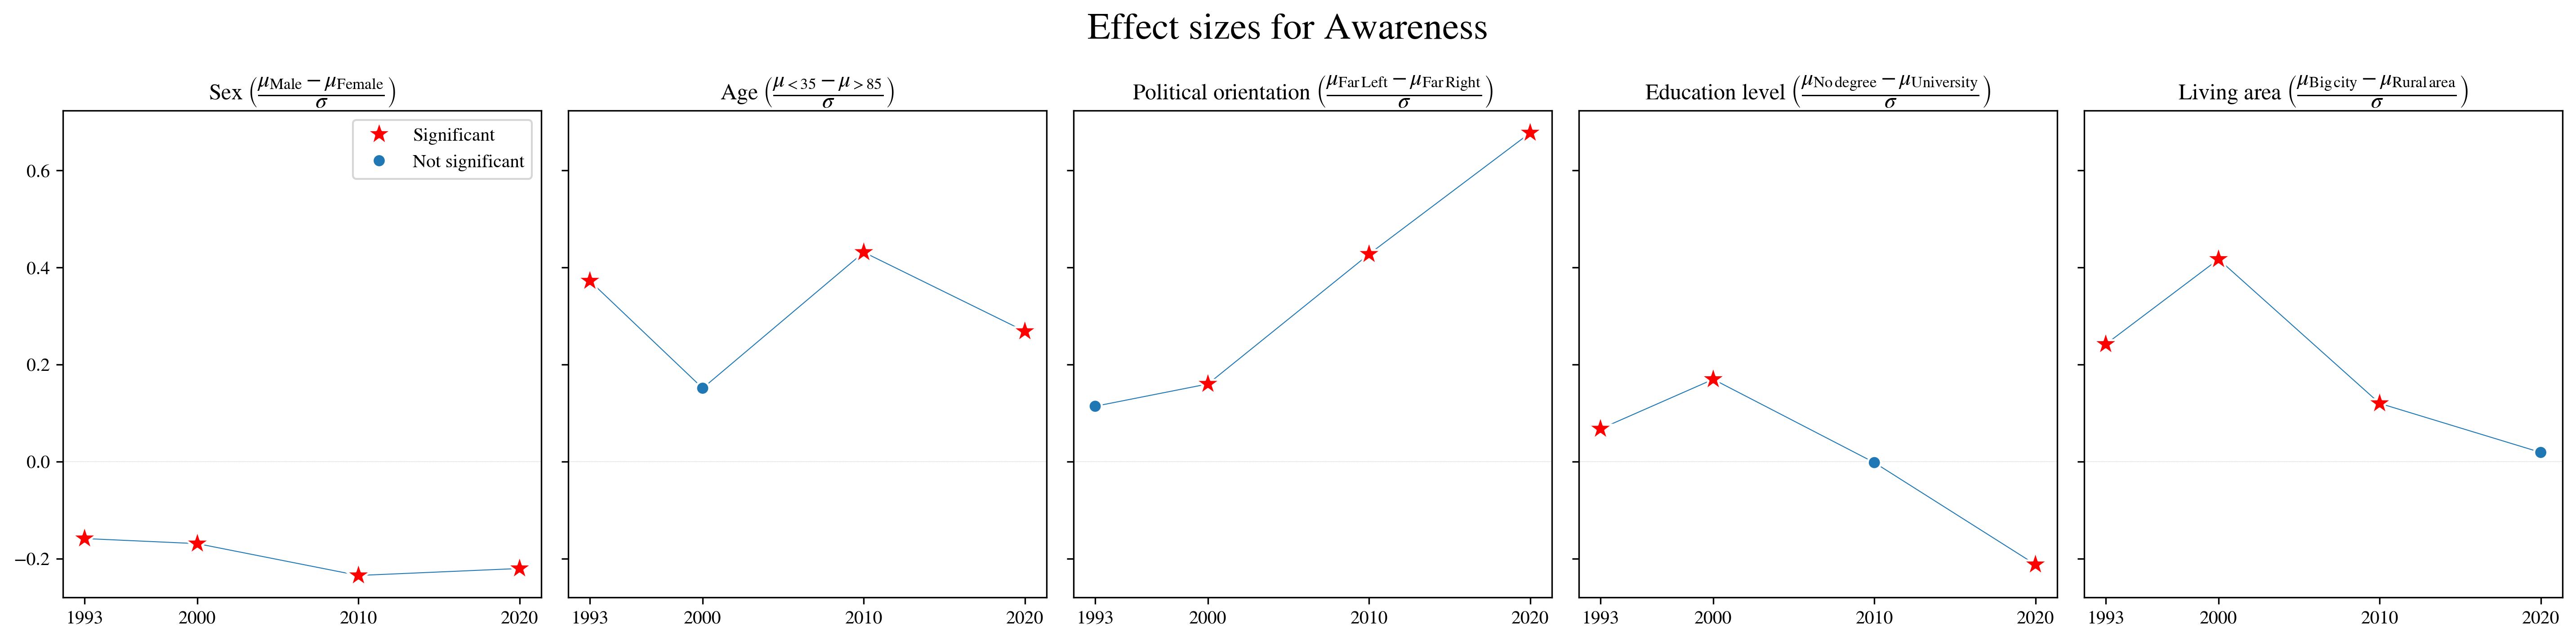

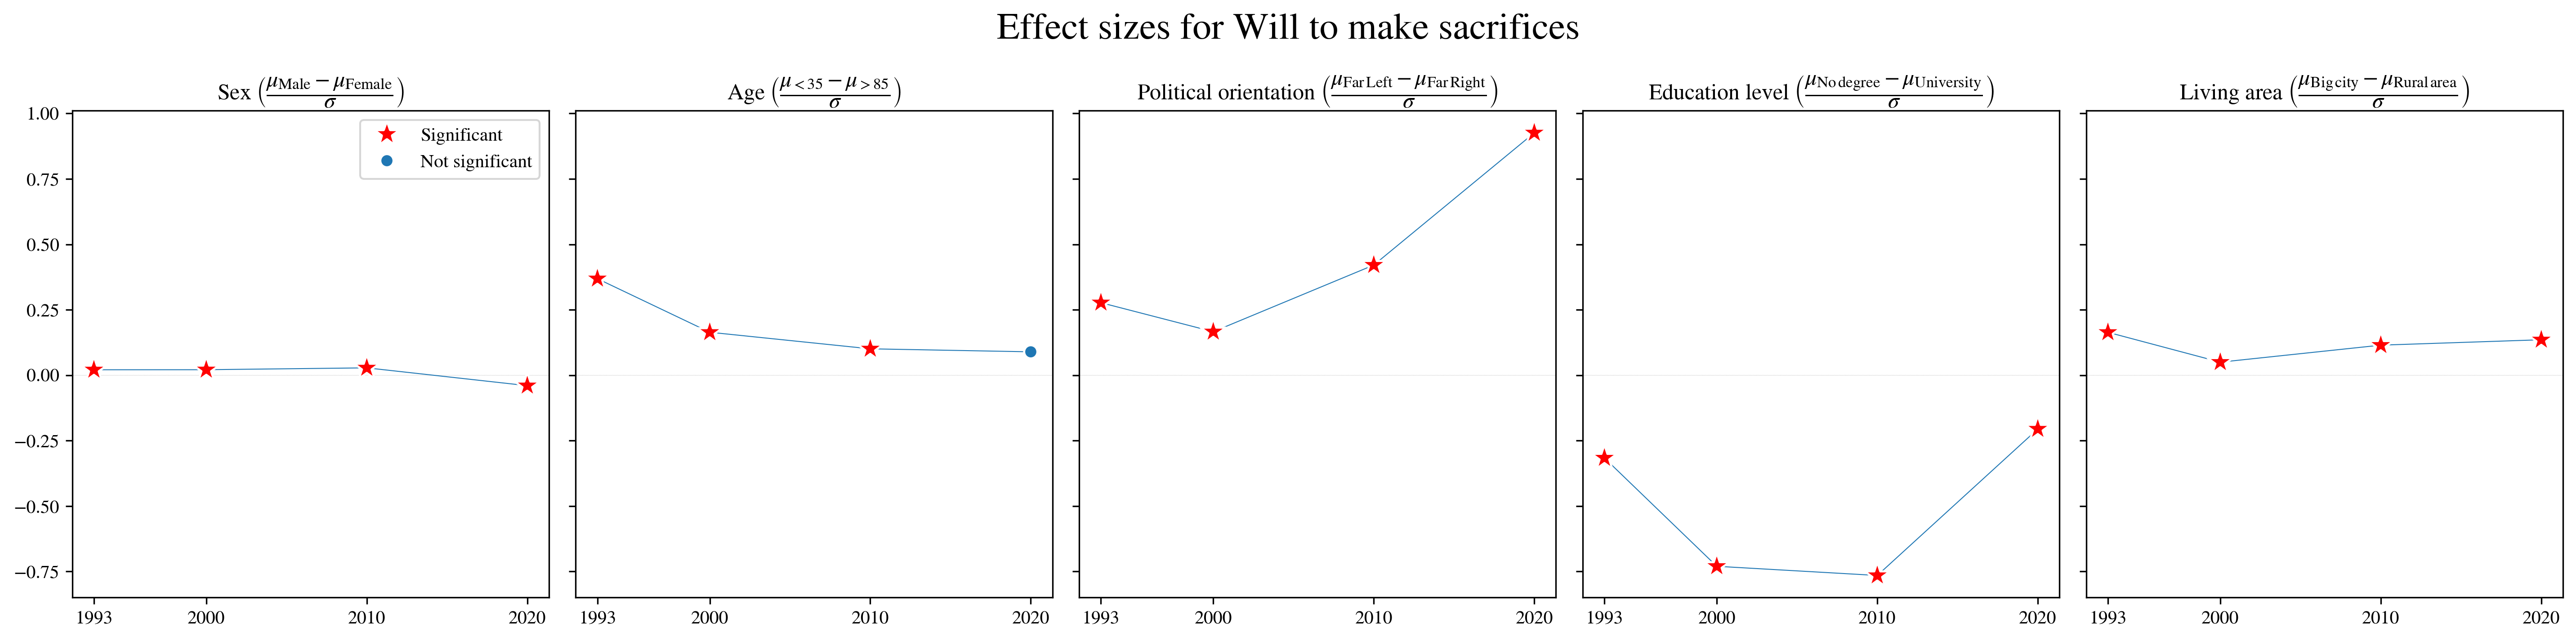

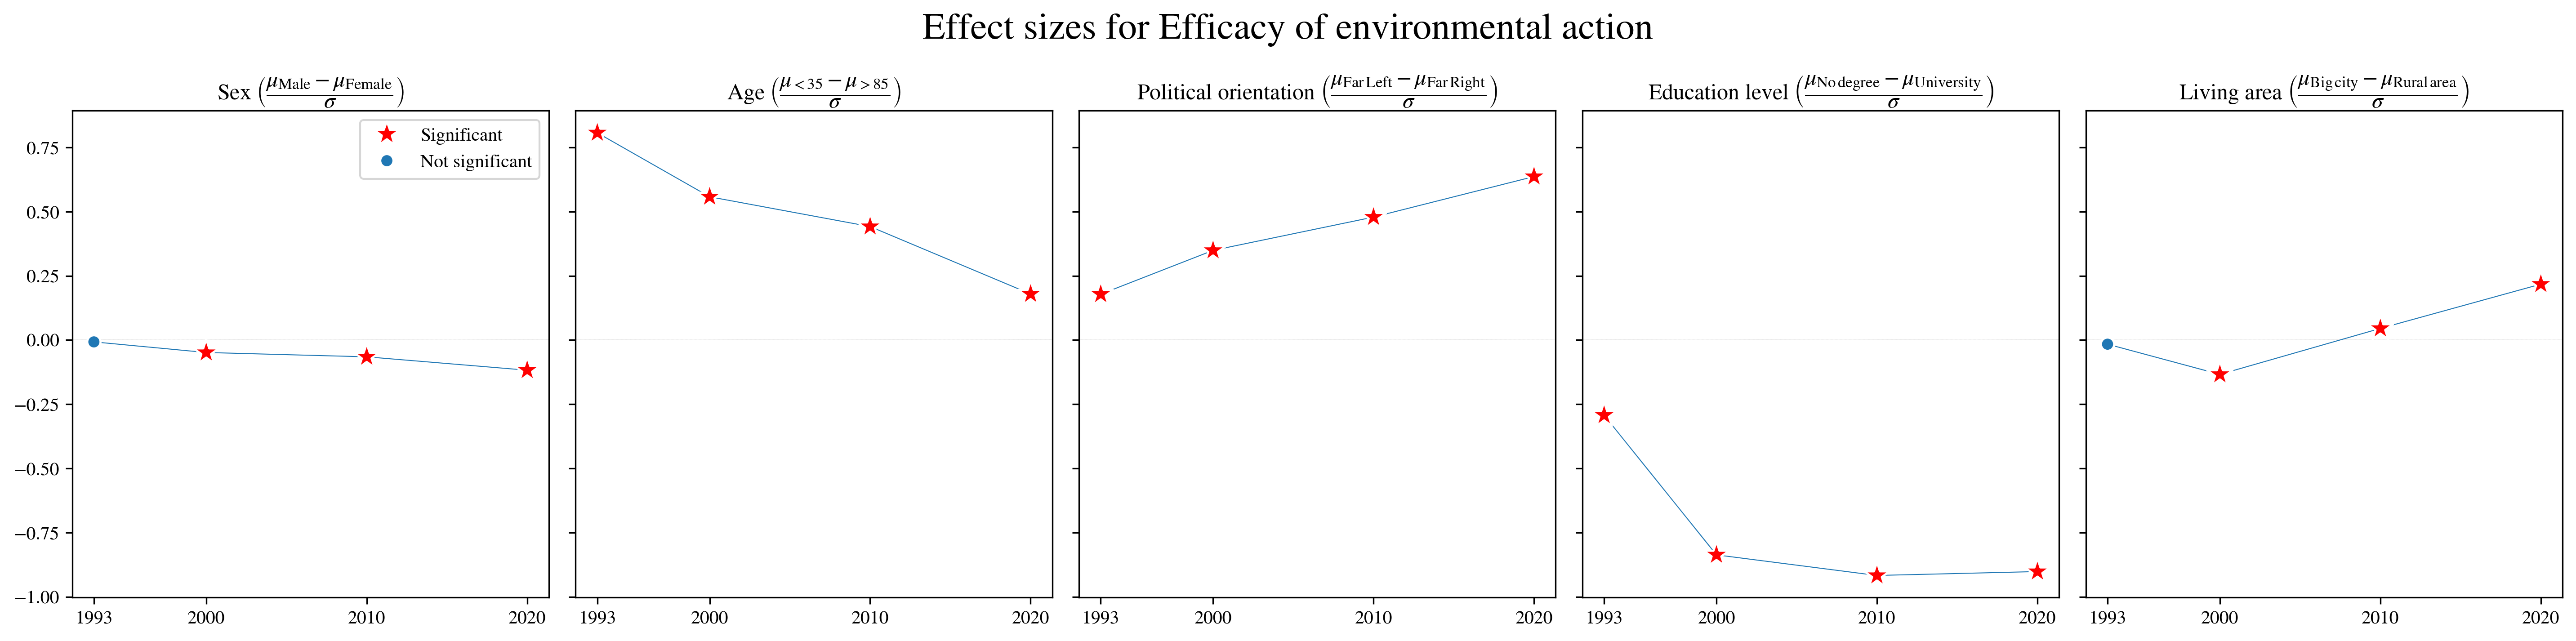

In [54]:
#plot effect size vs years for individual data

from scipy.stats import mannwhitneyu

indic_to_plot = {
    "Sex" : ["== 'Male'", " == 'Female'"],
    "Age" : ["<35", ">85"],
    "Political orientation" : ["=='Far Left'", "=='Far Right'"],
    "Education level" : ["=='No degree'", "=='University'"],
    "Living area" : ["== 'Big city'", " == 'Rural area'"],
}

effect_size_labels = {
    "Sex" : r"$\left(\dfrac{\mu_{\mathrm{Male}}-\mu_{\mathrm{Female}}}{\sigma}\right)$",
    "Age" : r"$\left(\dfrac{\mu_{<35}-\mu_{>85}}{\sigma}\right)$",
    "Political orientation" : r"$\left(\dfrac{\mu_{\mathrm{Far\,Left}}-\mu_{\mathrm{Far\,Right}}}{\sigma}\right)$",
    "Education level" : r"$\left(\dfrac{\mu_{\mathrm{No\,degree}}-\mu_{\mathrm{University}}}{\sigma}\right)$",
    "Living area" : r"$\left(\dfrac{\mu_{\mathrm{Big\,city}}-\mu_{\mathrm{Rural\,area}}}{\sigma}\right)$",
}   

for topic in data_issp_clustered.loc[:,"Environmental concern dimension"].columns:
    size_x, size_y = plt.rcParams["figure.figsize"]
    fig, axs = plt.subplots(1, 5, figsize=(3*size_x, size_y), sharey=True)
    fig.suptitle(f"Effect sizes for {topic}", size=20)
    for i, indicator in enumerate(indic_to_plot.keys()):
        effect_sizes = []
        significant = []
        for year in [1993, 2000, 2010, 2020]:
            df = data_issp_clustered.droplevel(axis=1, level=0).loc[year, [indicator, topic]]

            eff_size = (df.query(f"`{indicator}` {indic_to_plot[indicator][0]}")[topic].mean() - df.query(f"`{indicator}` {indic_to_plot[indicator][1]}")[topic].mean()) / df[topic].std()
            p_val = mannwhitneyu(df.query(f"`{indicator}` {indic_to_plot[indicator][0]}")[topic], df.query(f"`{indicator}` {indic_to_plot[indicator][1]}")[topic])[1]
            
            effect_sizes.append(eff_size)
            significant.append("Significant" if p_val < 0.05 else "Not significant")

            del(df)

        #plot
        ax = axs[i]
        ax.axline((1993,0,),(2020,0), lw=0.1, ls='--', color="gray", zorder=0)
        sns.lineplot(x=[1993, 2000, 2010, 2020], y=effect_sizes, lw=0.5, ax=ax, zorder=1)
        sns.scatterplot(x=[1993, 2000, 2010, 2020], y=effect_sizes, style=significant, hue=significant, palette = {"Significant" : "red", "Not significant" : sns.color_palette("tab10")[0]}, markers = {"Significant" : "*", "Not significant" : "."}, s=200, style_order=["Significant", "Not significant"], hue_order=["Significant", "Not significant"], ax=ax)
        
        ax.set_title(f"{indicator} {effect_size_labels[indicator]}")
        ax.set_xticks([1993,2000,2010,2020])

        if i>0:
            ax.get_legend().remove()
        plt.tight_layout()
        

    #plt.savefig(f"../Figures/effectSizes_{topic}.pdf", format="pdf")
        
        

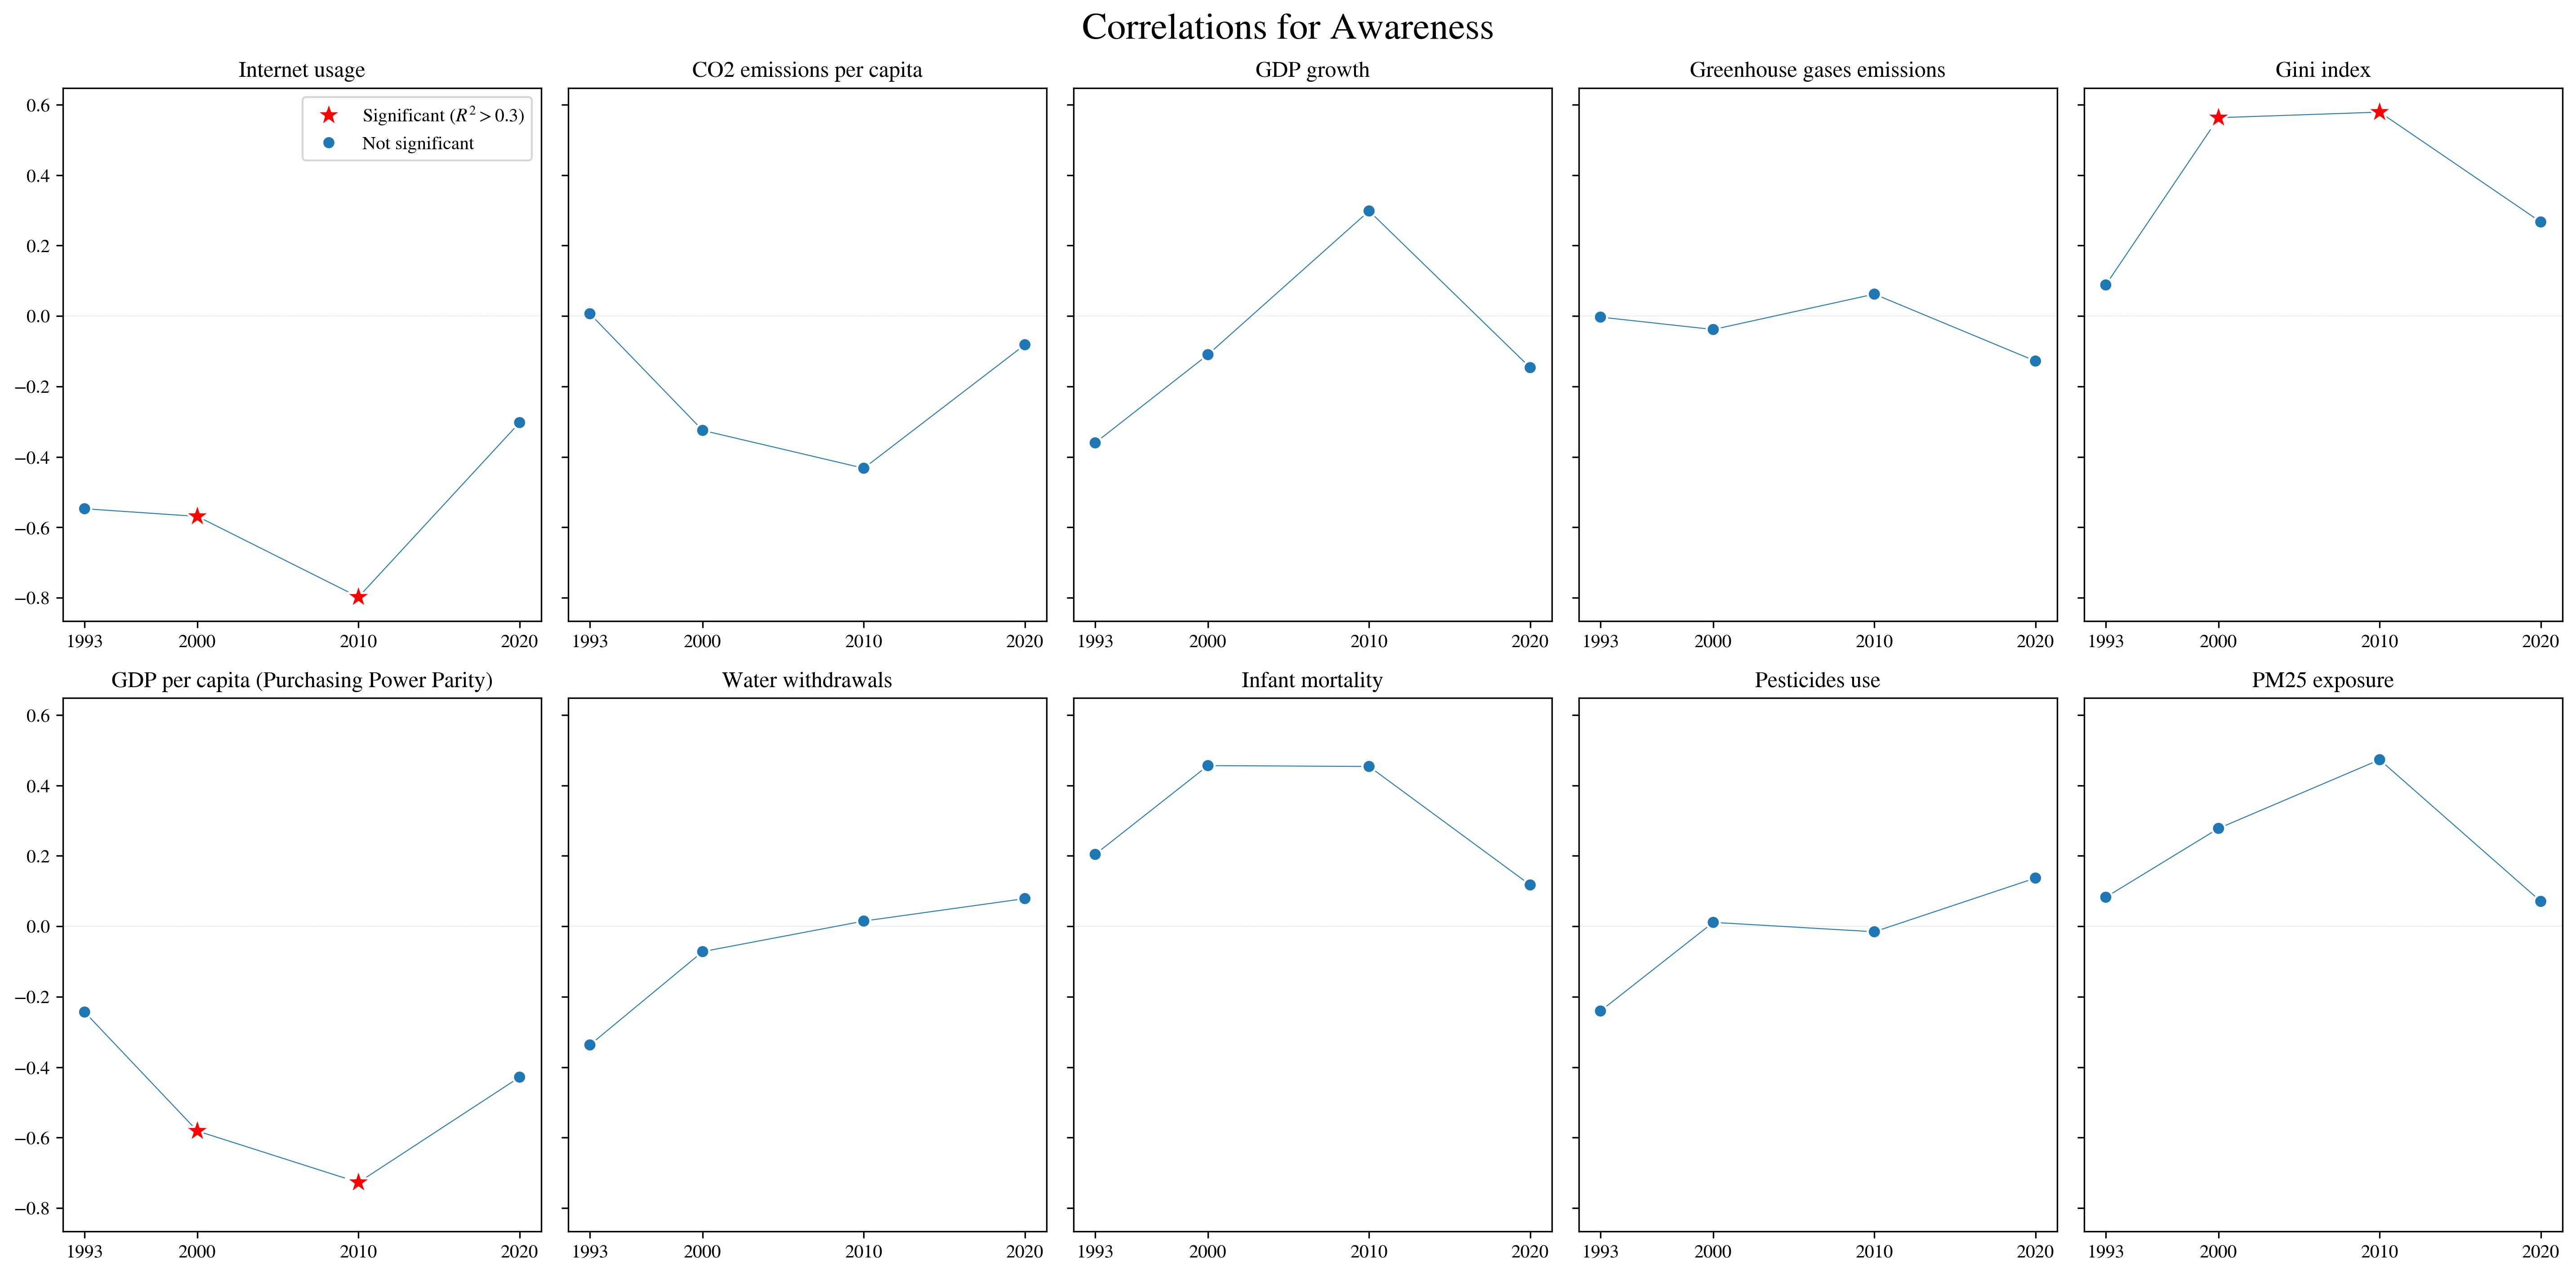

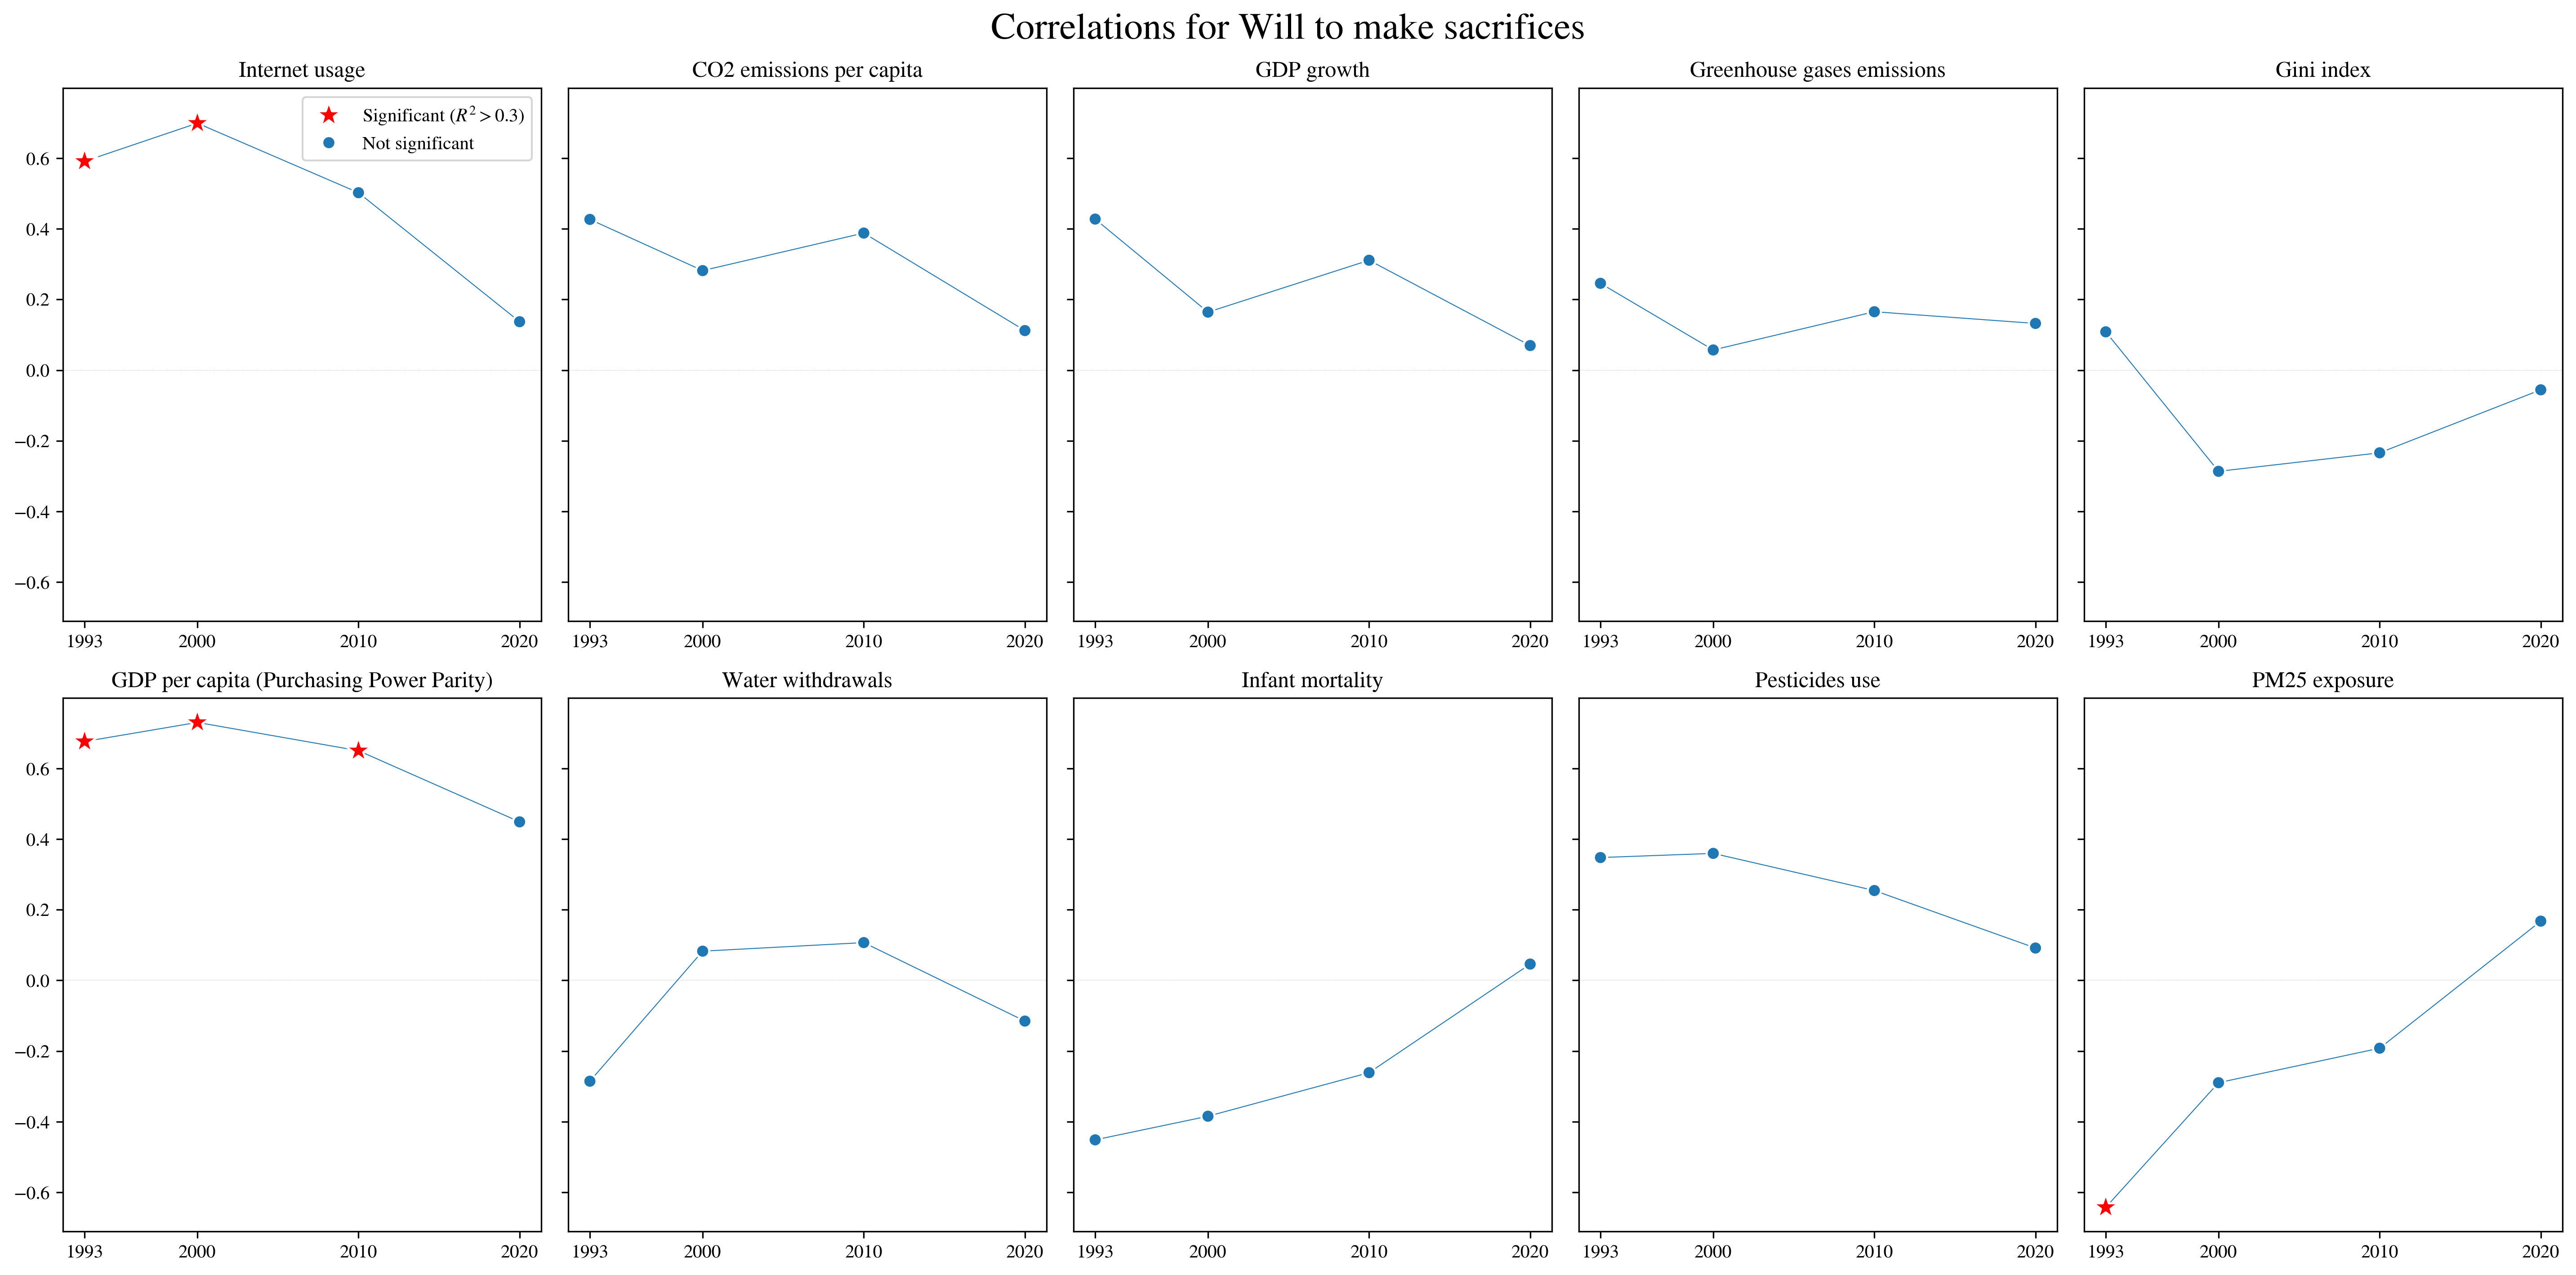

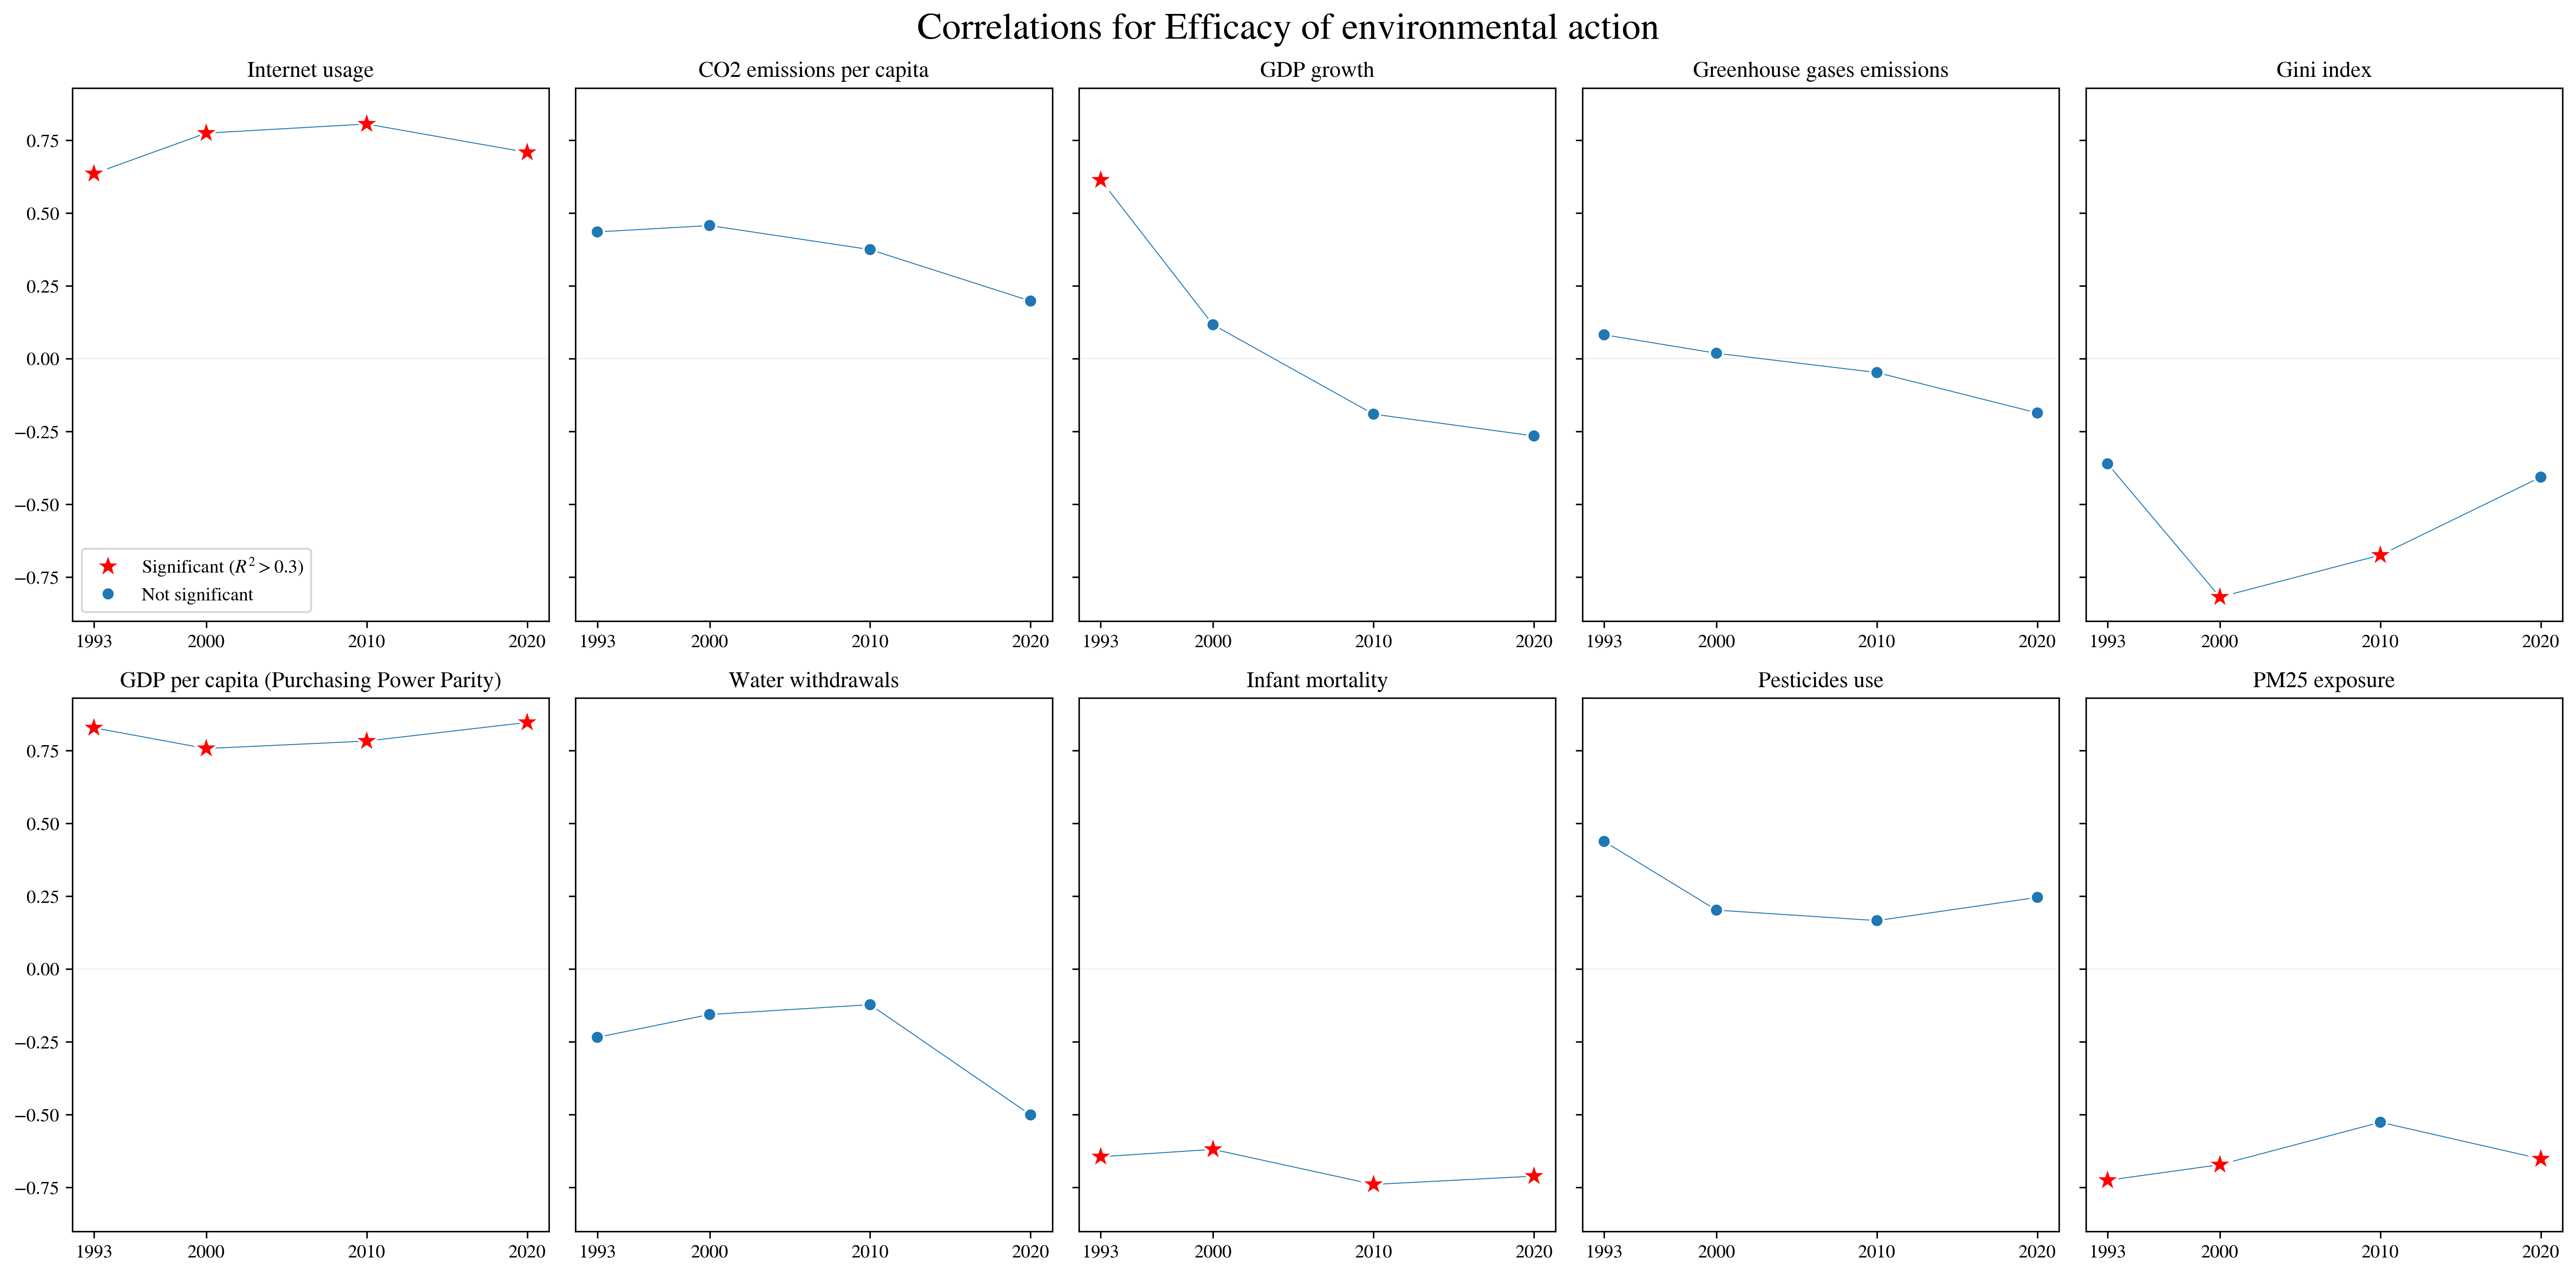

In [30]:
#plot correlation vs years for country-wide data

from sklearn.linear_model import LinearRegression

for topic in data_issp_clustered.loc[:,"Environmental concern dimension"].columns:
    size_x, size_y = plt.rcParams["figure.figsize"]
    fig, axs = plt.subplots(2, 5, figsize=(3*size_x, 2*size_y), sharey=True)
    fig.suptitle(f"Correlations for {topic}", size=20)
    for i, indicator in enumerate(data_issp_clustered.loc[:,"Country-wide indicators"].columns.drop("GDP per capita")):
        correlations = []
        significant = []
        for year in [1993, 2000, 2010, 2020]:
            df = data_issp_clustered.droplevel(axis=1, level=0).loc[year, [indicator, topic]].groupby("Country").mean()

            corr = df.corr().loc[indicator, topic]
            
            model = LinearRegression()
            model.fit(df.dropna()[[indicator]], df.dropna()[topic])
            R2 = model.score(df.dropna()[[indicator]], df.dropna()[topic])
            
            correlations.append(corr)
            significant.append(r"Significant $(R^2>0.3)$" if R2 > 0.3 else "Not significant")

            del(df)

        #plot
        ax = axs[i//5,i%5]
        ax.axline((1993,0,),(2020,0), lw=0.1, ls='--', color="gray", zorder=0)
        sns.lineplot(x=[1993, 2000, 2010, 2020], y=correlations, lw=0.5, ax=ax, zorder=1)
        sns.scatterplot(x=[1993, 2000, 2010, 2020], y=correlations, style=significant, hue=significant, palette = {r"Significant $(R^2>0.3)$" : "red", "Not significant" : sns.color_palette("tab10")[0]}, markers = {r"Significant $(R^2>0.3)$" : "*", "Not significant" : "."}, s=200, style_order=[r"Significant $(R^2>0.3)$", "Not significant"], hue_order=[r"Significant $(R^2>0.3)$", "Not significant"], ax=ax)
        
        ax.set_title(f"{indicator}")
        ax.set_xticks([1993,2000,2010,2020])

        if i>0:
            ax.get_legend().remove()
        plt.tight_layout()

    plt.savefig(f"../Figures/correlations_{topic}_vs_macroind.pdf", format="pdf")

___
# Countries comparison

/var/folders/mv/3xxn6x011nj1xbbrht5z6r1m0000gn/T/ipykernel_1828/3966151813.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)
/var/folders/mv/3xxn6x011nj1xbbrht5z6r1m0000gn/T/ipykernel_1828/3966151813.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)
/var/folders/mv/3xxn6x011nj1xbbrht5z6r1m0000gn/T/ipykernel_1828/3966151813.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)


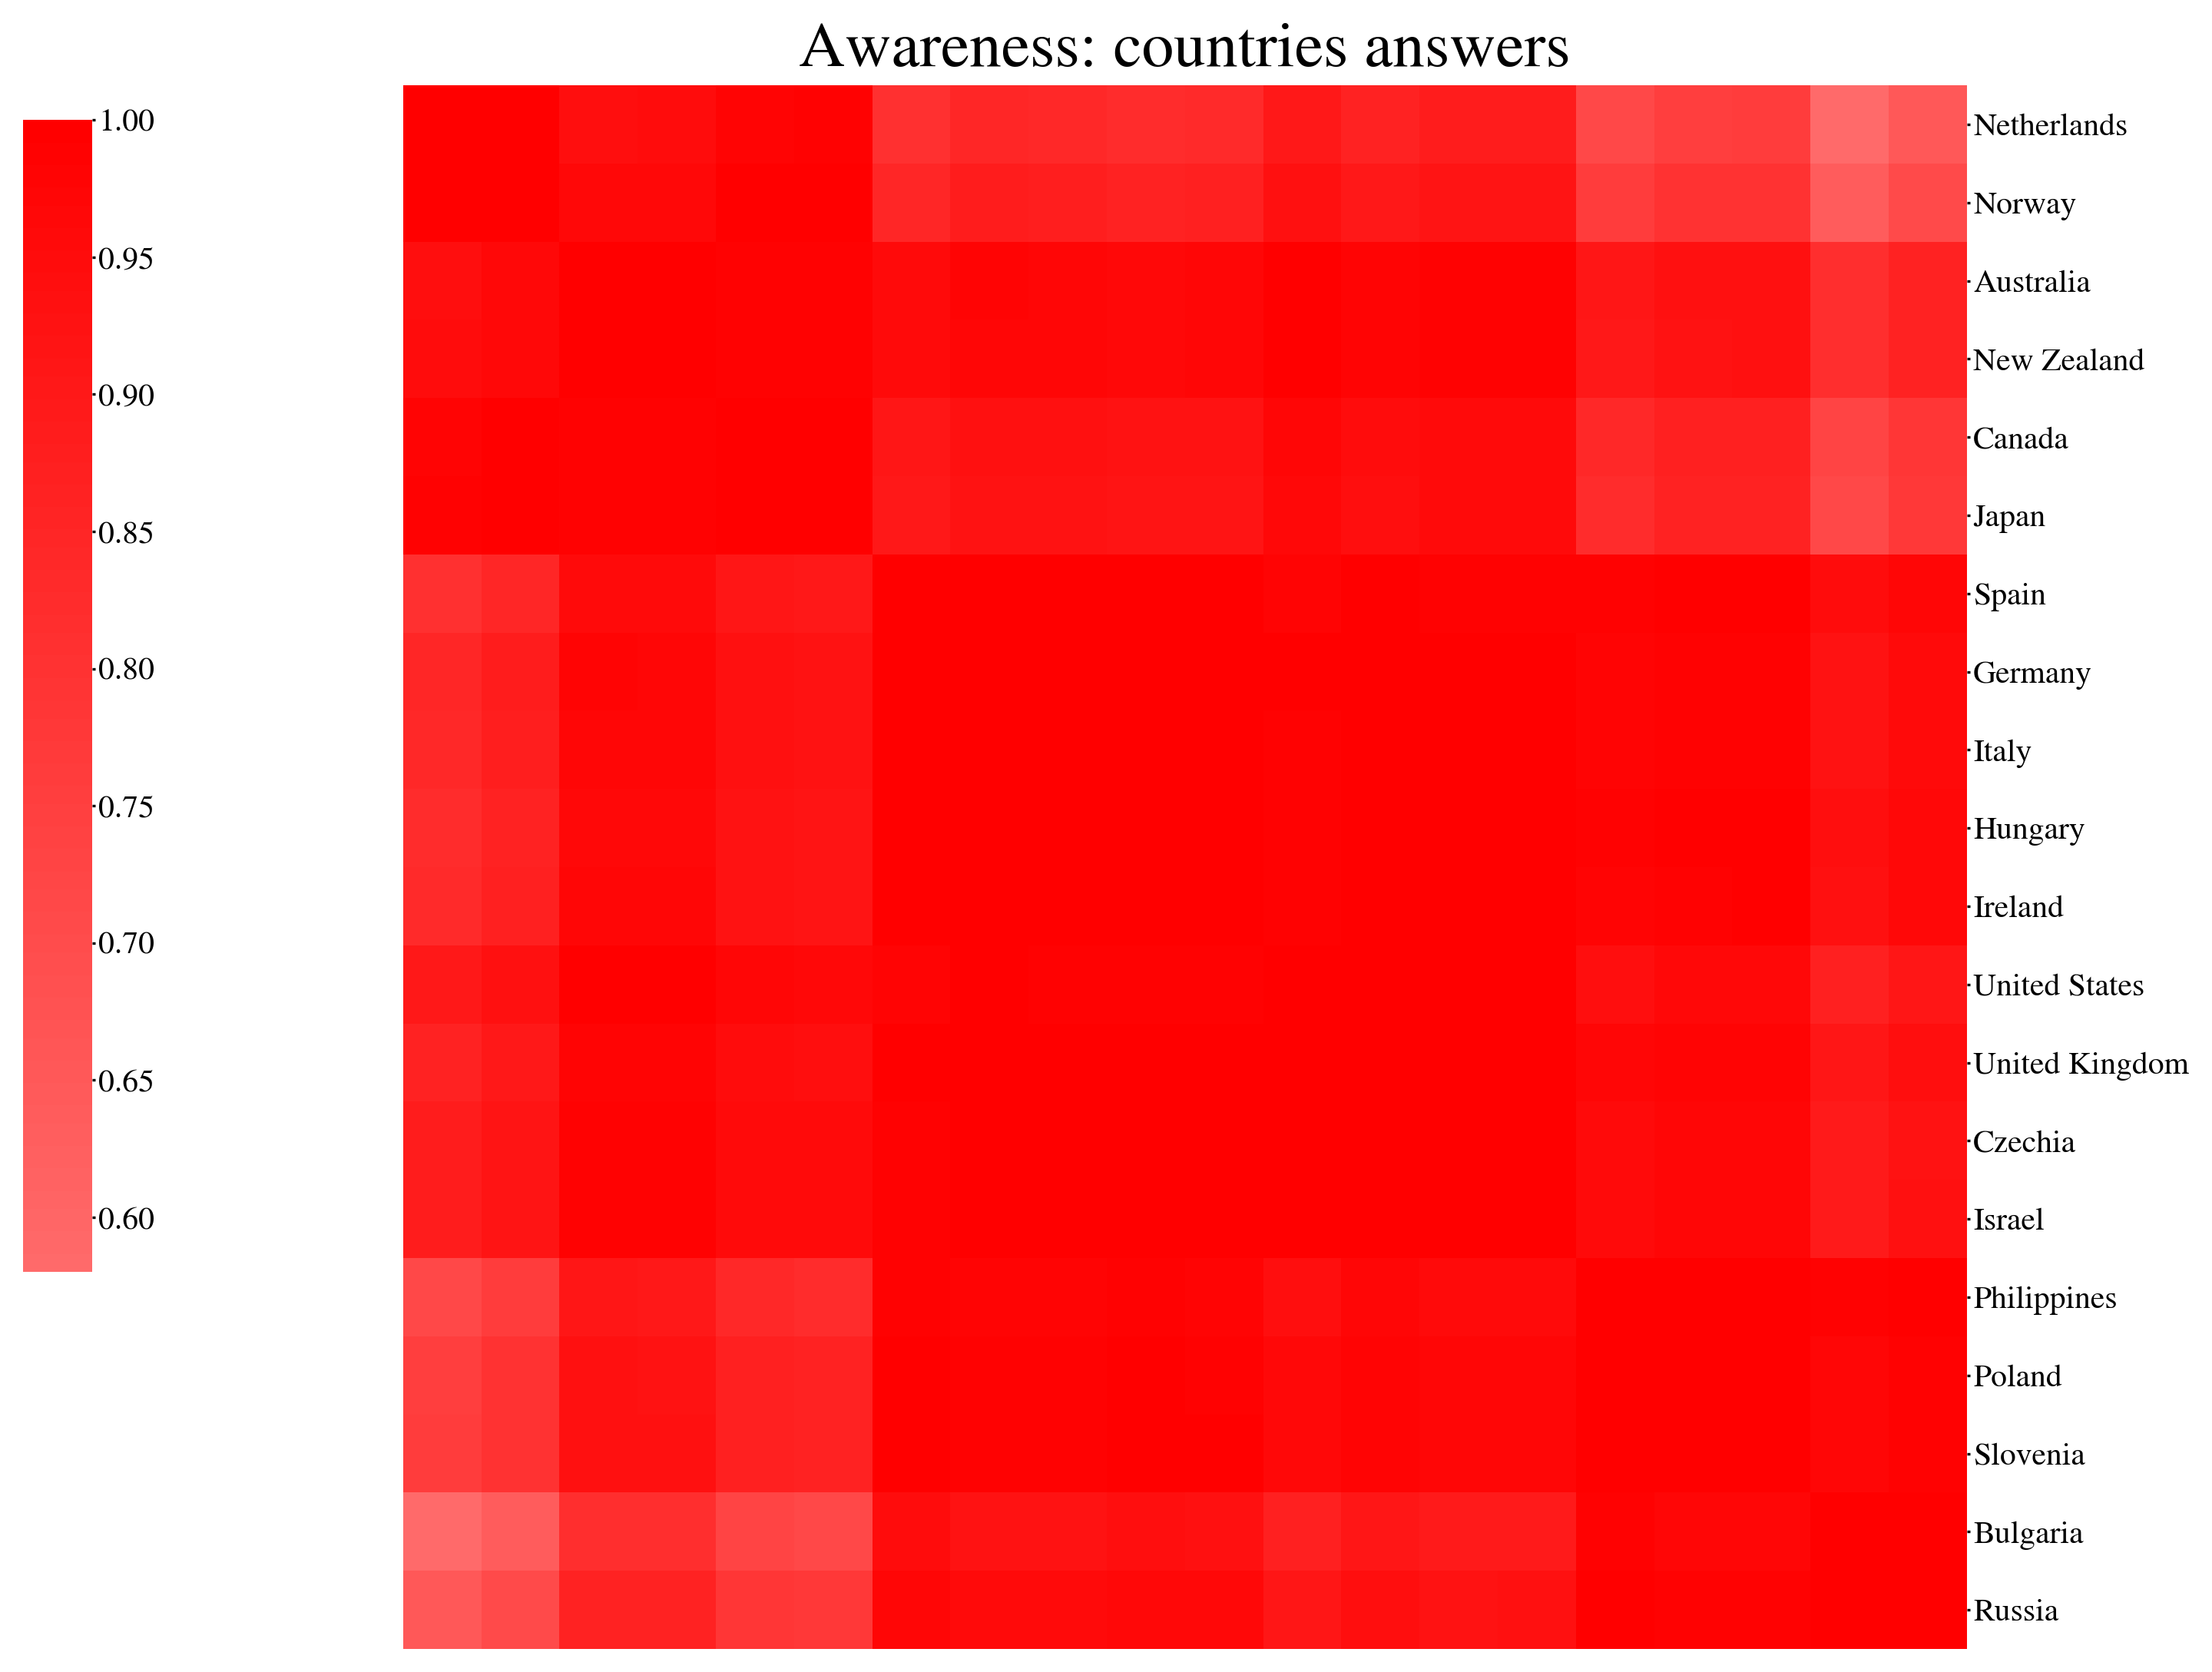

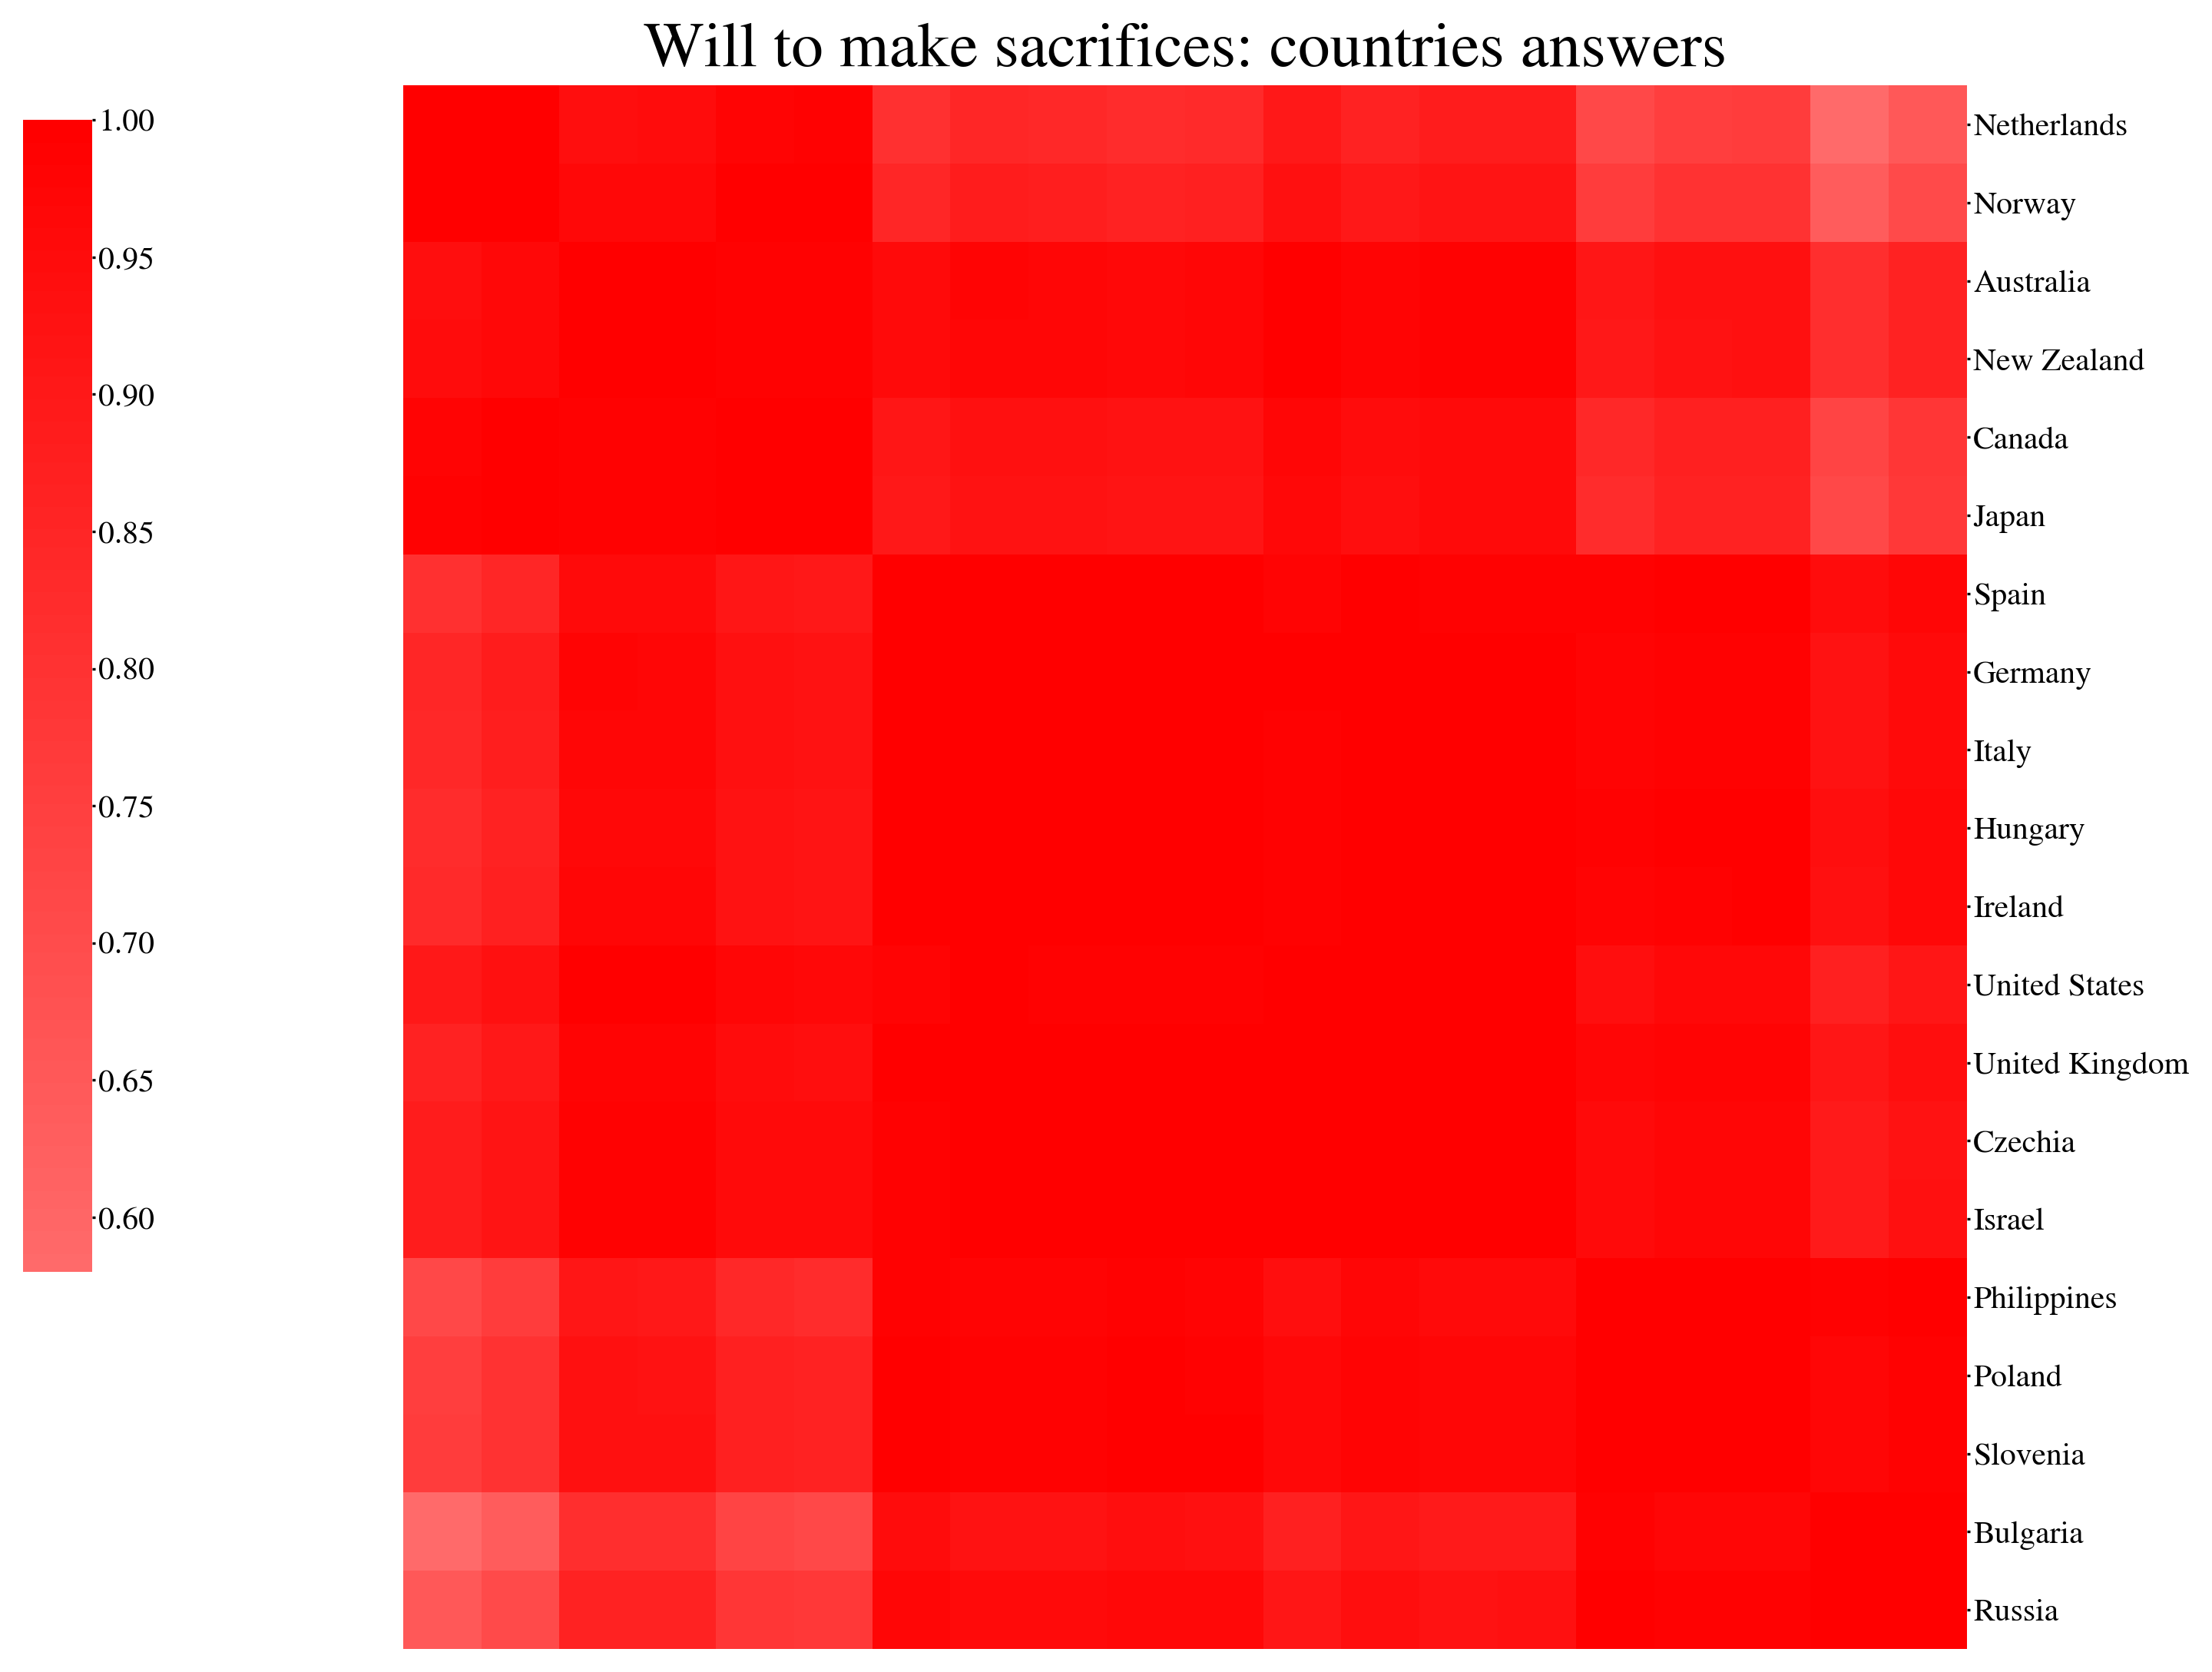

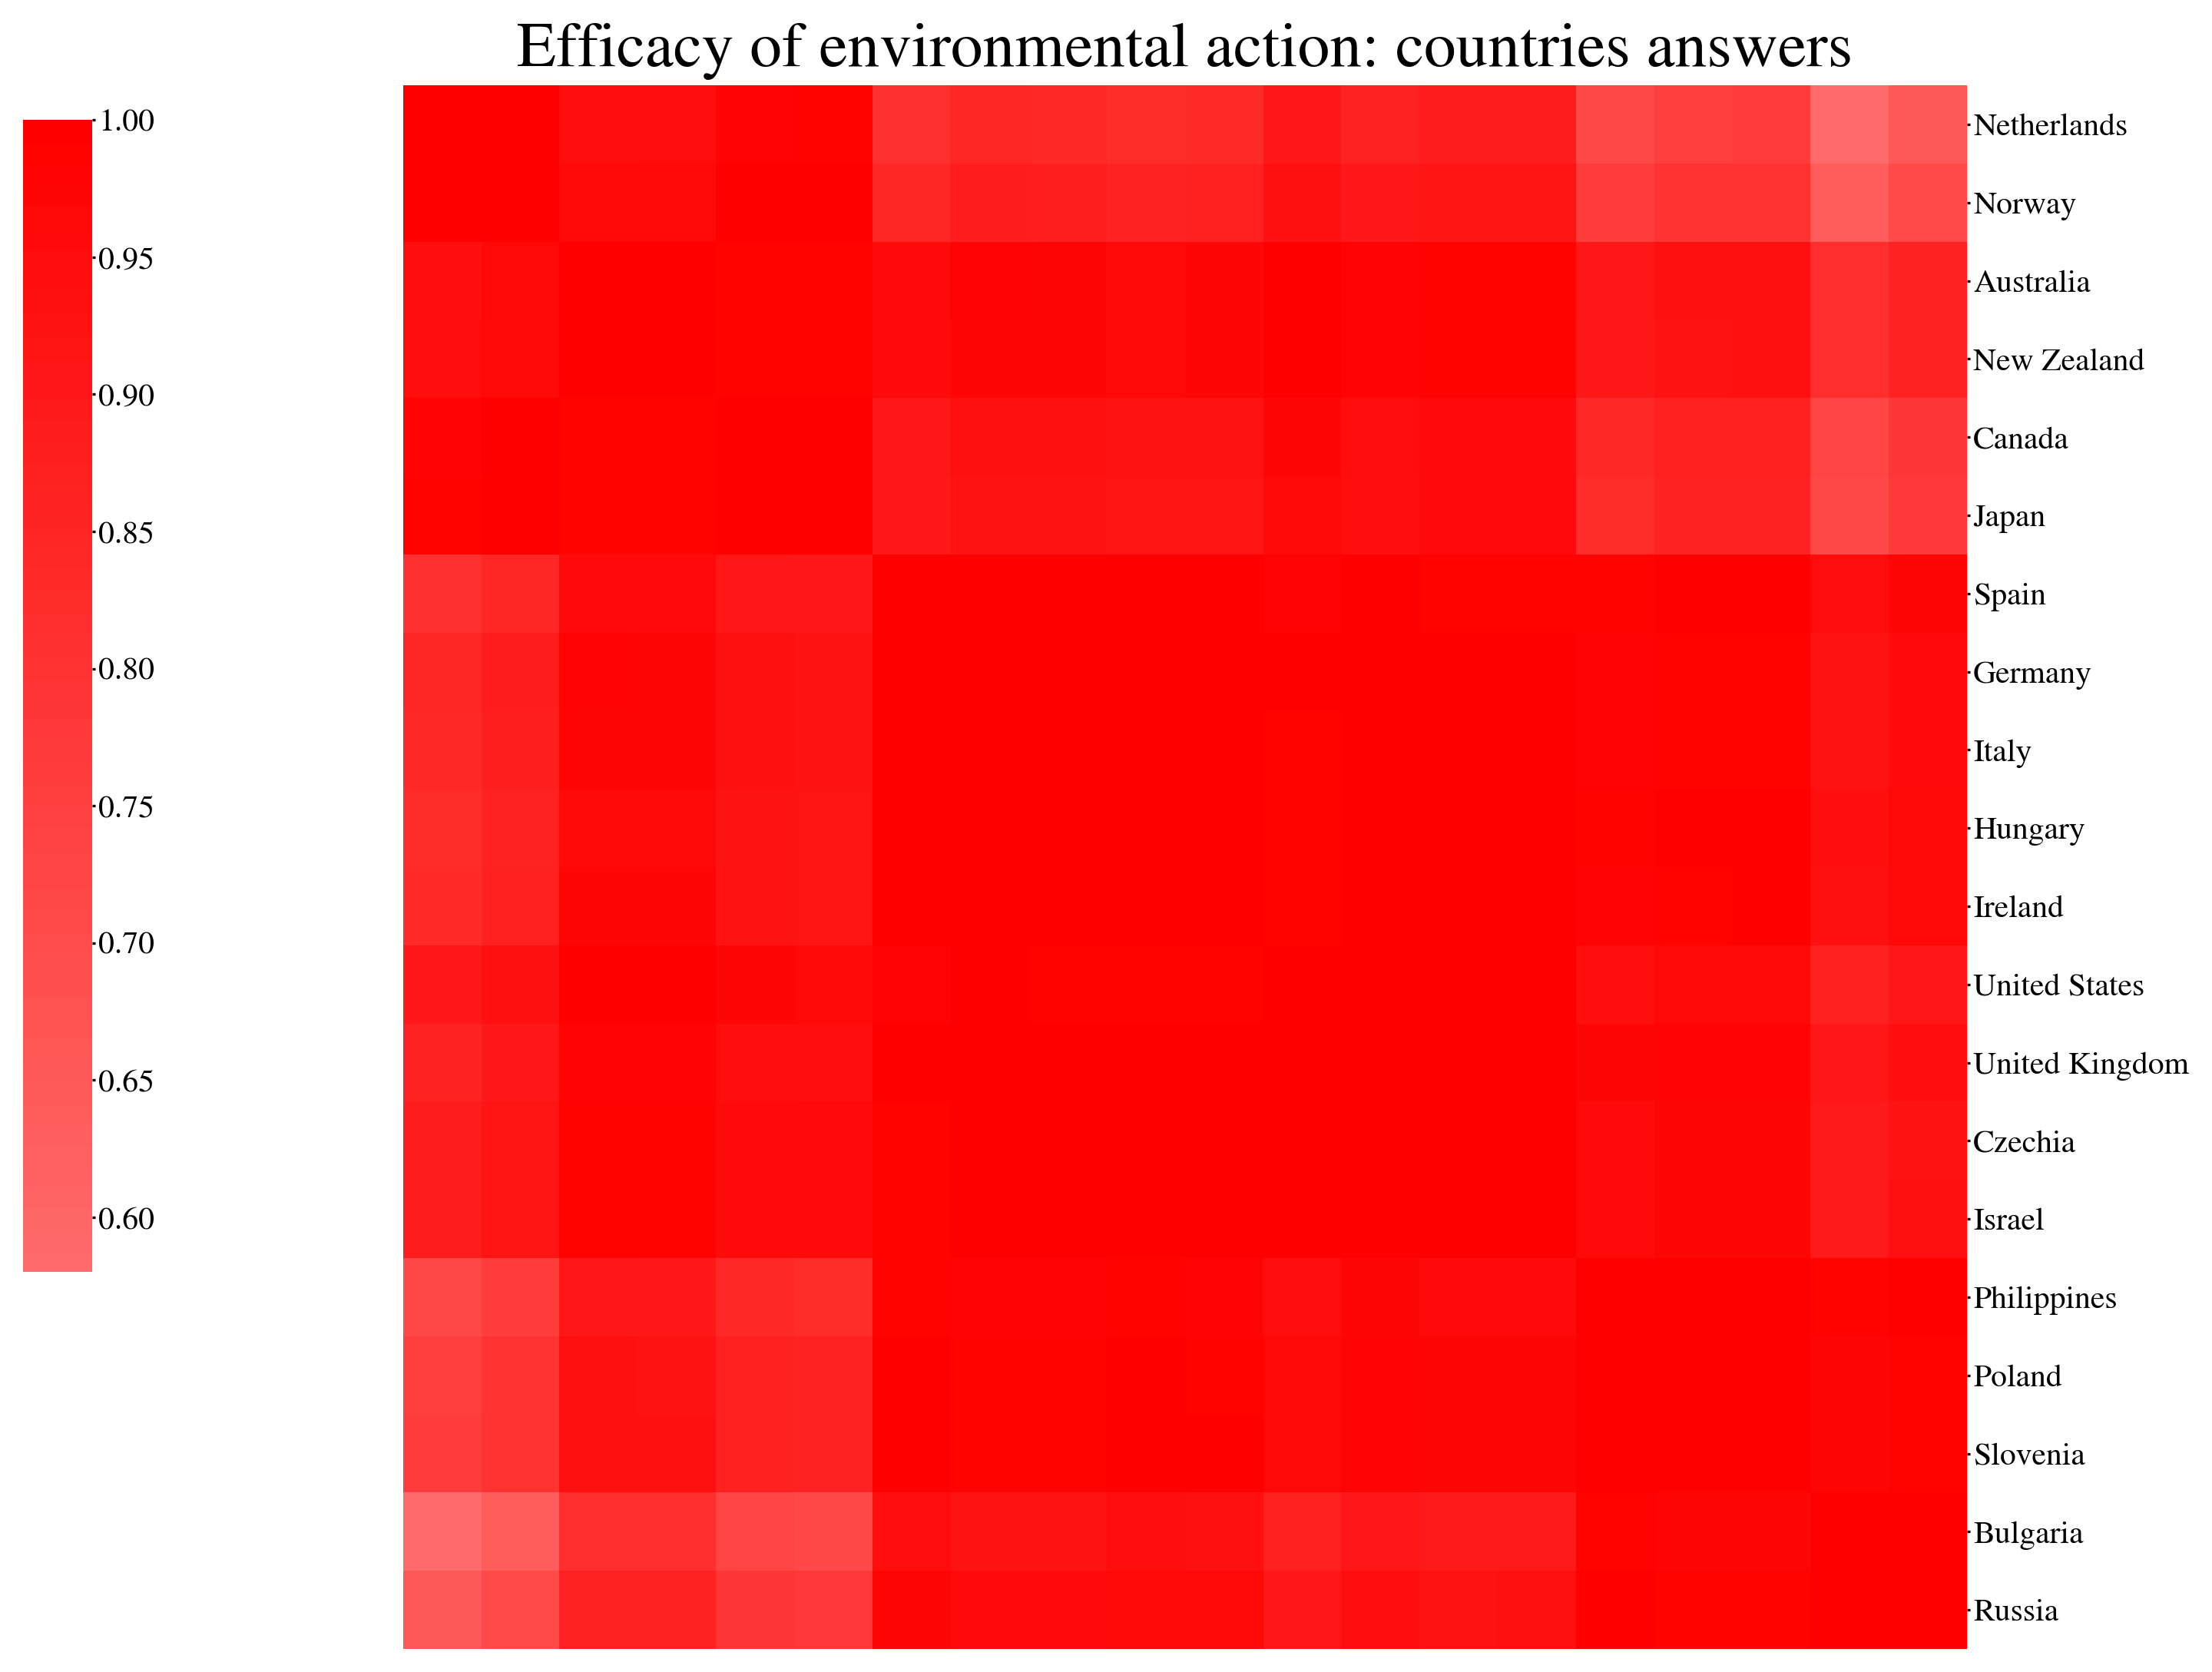

In [66]:
data_issp = pd.read_pickle("../Saved_variables/full_dataset_numerical_clustered.pickle").loc[:,"Environmental concern dimension"] / [12,11,8]
data = data_issp.groupby(["Year", "Country"]).mean()

year = 1993
for topic in data.columns:
    corr_matrix = data.loc[year].groupby("Country").mean().T.corr()
    
    clm = sns.clustermap(corr_matrix, cmap="bwr", center=0, cbar_pos=(0.02, 0.3, 0.03, 0.5), method="ward")
    clm.ax_row_dendrogram.set_visible(False)
    clm.ax_col_dendrogram.set_visible(False)
    clm.tick_params(size=1, pad=1, labelsize=6)
    clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_ymajorticklabels(), fontsize=10)
    clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(), fontsize=10)
    
    clm.ax_heatmap.set_title(f"{topic}: countries answers", fontsize=20);
    clm.ax_heatmap.set_xticks([])
    clm.ax_heatmap.set_xlabel("")
    clm.ax_heatmap.set_ylabel("")

___

In [71]:
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm

In [68]:
data_issp = pd.read_pickle("../Saved_variables/full_dataset_numerical_clustered.pickle").loc[:,"Environmental concern dimension"] / [12,11,8]
data = data_issp.groupby(["Year", "Country"]).mean()
data["geometry"] = worldmap.loc[data.index.get_level_values("Country"), "geometry"].values
data = gpd.GeoDataFrame(data)

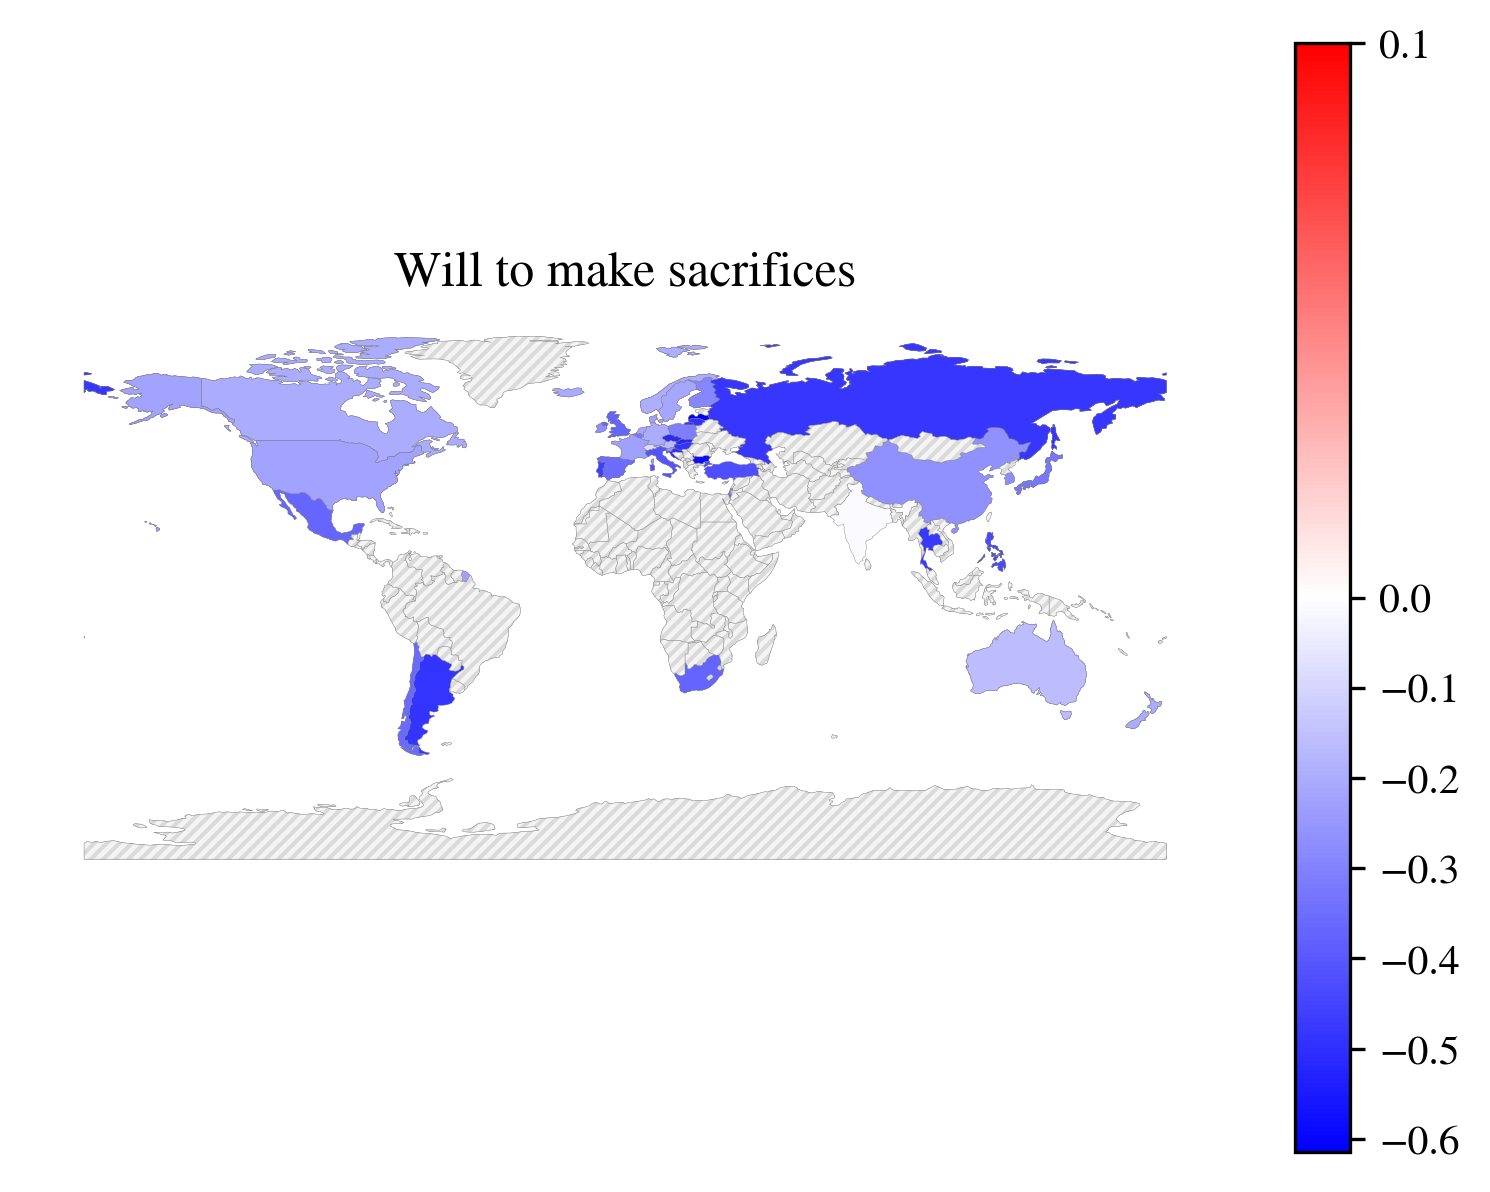

In [89]:
fig, ax = plt.subplots()
topic="Will to make sacrifices"

max=data.loc[:,topic].abs().max()
ax.set_title(topic)

vmin = data.loc[:,topic].min() if data.loc[:,topic].min()<0 else -0.1
vmax = data.loc[:,topic].max() if data.loc[:,topic].max()>0 else 0.1
vcenter = 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# create a normalized colorbar
cmap = 'bwr'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)


data.plot(topic, cmap=cmap, vmin=-max, vmax=max, norm=norm, edgecolor="gray", linewidth=0.1, ax=ax, legend=False)
worldmap.query("in_issp_1993 == False and in_issp_2000 == False and in_issp_2010 == False and in_issp_2020 == False").plot(color=[1,1,1], edgecolor="gray", linewidth=0.1, hatch="////////", ax=ax)
worldmap.query("in_issp_1993 == False and in_issp_2000 == False and in_issp_2010 == False and in_issp_2020 == False").plot(edgecolor="gray", linewidth=0.1, color=[0.95,0.95,0.95], alpha=0.8, ax=ax)

fig.colorbar(cbar, ax=ax)

plt.axis("off");